## Input Parameters

In [1]:

#source EPOTFenv/bin/activate (launching and exiting the virtual environment containing the required modules, stored in the working directory)
#EPOTFenv/bin/python your_script.py - for running a script in the virtual environment
#source deactivate

#import all the libraries needed
from import_dep import *
# import custom plot style and colorbar functions
from plot_style import set_plot_style, add_colorbar, generate_colormaps_and_normalizers

# import the data import functions 
from data_import import PPMSData, import_ppms_data, import_all_datasets

# import my functions stored in the file 'VDP_functions' which can then be called with VDOP_functions.function_name()
import VDP_functions

# import the fitting functions
from fitting_functions import poly_to_string

### Plotting and Output Variables 
export_data = False # set to True to export the data to a powerpoint presentation and as svg files and export to path_out
powerpoint_string = 'WP1' # string to be added to the powerpoint file name
fig_format = 'svg' # format of the figure to be saved
plot_transparency = True # set to True to make the data plots transparent

ohm_m = 0 #set to 1 to force ohm-m units 0 to keep micro ohm cm units



# Custom Scence style settings for figures
fig_size = set_plot_style(export_data, use_tex=True)
#plt.style.use(['science', 'grid', 'nature'])

# Import all the measured data
dat_raw = import_all_datasets()

File 1 imported: JT029_SrRuO3_silver_Combined with shape (650, 5, 6)
File 2 imported: JT029_SrRuO3_silver_Combined4 with shape (7920, 5, 6)
File 3 imported: JT029_SrRuO3_silver_Combined_fullrange.txt with shape (850, 5, 6)
File 4 imported: JT029_SrRuO3_silver_HallRun1 with shape (72, 5, 6)
File 5 imported: JT029_SrRuO3_silver_Halltest2 with shape (68, 5, 6)
File 1 imported: HC003_BaSnO3_STO_061124_Hall with shape (3024, 5, 6)
File 1 imported: YF042_HfO2_STO_nosilver_Hall_2 with shape (3660, 5, 6)
File 2 imported: YF042_HfO2_STO_silver_Hall_3 with shape (2970, 5, 6)
File 3 imported: YF042_HfO2_STO_silver_Hall_5 with shape (2508, 5, 6)
File 4 imported: YF042_HfO2_STO_silver_Hall_6 with shape (2442, 5, 6)
File 5 imported: YF042_HfO2_STO_silver_Hall_7 with shape (3080, 5, 6)
Error with file: YFW042_HZO_IV_resistivity.png, 'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
File 1 imported: DR001_LaScO3__BaSnO3_STO_201124_test1 with shape (22, 5, 6)
File 2 imported: DR004

## Instrument Applied Current Approximation
- Keep below this level to prevent joule heating based off the two terminal resistance

In [2]:

R_approx = (2e6)
a = (1000*R_approx)**(-0.5)
print(f'Use Current < {a:.1e} A')

Use Current < 2.2e-05 A


## Select Data for Plotting ***********************************************

In [3]:
# First visualise the data contained in each list
for count, dat in enumerate(dat_raw):
    print(f'dat_{count}:', [f'{count_2}={d.filename}' for count_2, d in enumerate(dat)])


# Select the data sets to be plotted and put into a single list

#dat_raw_sel = [dat_raw[0][2], dat_raw[0][0], dat_raw[0][1]] # JT029
#dat_raw_sel = [dat_raw[20][0],dat_raw[20][5]] # JT082

#dat_raw_sel = [dat_raw[3][1]] # DR001
#dat_raw_sel = [dat_raw[4][5], dat_raw[4][7], dat_raw[4][9]] # , dat_raw[4][10], dat_raw[4][11],dat_raw[4][12]] # DR003
#dat_raw_sel = [dat_raw[3][0],dat_raw[3][1], dat_raw[3][2], dat_raw[3][3]] # DR004
#dat_raw_sel =  [dat_raw[14][5], dat_raw[14][1], dat_raw[14][7]]#, dat_raw[14][2]] # DR008a
#dat_raw_sel = [ dat_raw[17][4],dat_raw[17][3],dat_raw[17][2], dat_raw[17][0]] #dat_raw[17][1],  dat_raw[17][0],   ] # DR009
#dat_raw_sel = [ dat_raw[18][2], dat_raw[18][0], dat_raw[18][3] ] # DR010
dat_raw_sel = [dat_raw[21][2], dat_raw[21][1], dat_raw[21][3], ] # DR011
#dat_raw_sel = [ dat_raw[19][4], dat_raw[19][3], dat_raw[19][2]]#, dat_raw[19][0]] # DR012
#dat_raw_sel = [ dat_raw[21][0], dat_raw[19][4], dat_raw[19][3], dat_raw[17][4] , dat_raw[18][1],dat_raw[18][3],dat_raw[18][0], dat_raw[14][5], dat_raw[14][1], dat_raw[14][7]] # DR Combined

#dat_raw_sel = [dat_raw[2][3] , dat_raw[2][2],  dat_raw[2][4], dat_raw[2][1]] # YFW042
#dat_raw_sel = [dat_raw[8][1], dat_raw[8][2]]    #,dat_raw[2][4],dat_raw[2][5]] YFW044
#dat_raw_sel = [ dat_raw[9][1], dat_raw[9][2], dat_raw[9][4]] #YFW046
#dat_raw_sel = [dat_raw[2][1], dat_raw[2][2], dat_raw[2][3], dat_raw[2][4], dat_raw[8][1], dat_raw[8][2], dat_raw[9][4]] # YFW Combined

#dat_raw_sel = dat_raw[1] # HC003
#dat_raw_sel = [dat_raw[10][0], dat_raw[10][4]] # HC011 ********* THE CURRENT IS INVERTED FOR THIS SAMPLE!!! **********
#dat_raw_sel = [dat_raw[11][0],dat_raw[11][4]] #,dat_raw[11][5]] # HC013
#dat_raw_sel = [dat_raw[12][3], dat_raw[12][0],dat_raw[12][1],dat_raw[12][2]] # HC014
#dat_raw_sel = [dat_raw[15][1], dat_raw[15][2]] #HC016
#dat_raw_sel = [dat_raw[16][1]]  #HC015
#dat_raw_sel = [dat_raw[15][1], dat_raw[11][0],dat_raw[11][4],dat_raw[10][0], dat_raw[10][4],dat_raw[16][1]] # HC Combined

# 2DEG combined
#dat_raw_sel = [dat_raw[20][0],dat_raw[18][1],dat_raw[18][3],dat_raw[18][0],dat_raw[17][4],dat_raw[10][0], dat_raw[10][4], dat_raw[4][7], dat_raw[2][4], dat_raw[2][1], dat_raw[8][1],dat_raw[9][4], dat_raw[11][0],dat_raw[11][4],dat_raw[14][1],dat_raw[16][1], dat_raw[15][1]] 


#dat_raw_sel = [dat_raw[13][5], dat_raw[13][2], dat_raw[13][3]] # DV127

print('dat_raw_sel:', [f'{count}={d.filename}' for count, d in enumerate(dat_raw_sel)])


dat_0: ['0=JT029_SrRuO3_silver_Combined', '1=JT029_SrRuO3_silver_Combined4', '2=JT029_SrRuO3_silver_Combined_fullrange.txt', '3=JT029_SrRuO3_silver_HallRun1', '4=JT029_SrRuO3_silver_Halltest2']
dat_1: ['0=HC003_BaSnO3_STO_061124_Hall']
dat_2: ['0=YF042_HfO2_STO_nosilver_Hall_2', '1=YF042_HfO2_STO_silver_Hall_3', '2=YF042_HfO2_STO_silver_Hall_5', '3=YF042_HfO2_STO_silver_Hall_6', '4=YF042_HfO2_STO_silver_Hall_7']
dat_3: ['0=DR001_LaScO3__BaSnO3_STO_201124_test1', '1=DR004_LaScO3__BaSnO3_STO_201124_combined3', '2=DR004_LaScO3__BaSnO3_STO_201124_combined4', '3=DR004_LaScO3__BaSnO3_STO_201124_combined5', '4=DR004_LaScO3__BaSnO3_STO_201124_combined6', '5=DR004_LaScO3__BaSnO3_STO_201124_test2']
dat_4: ['0=DR003_LaScO3__BaSnO3_STO_nosilver_combined1', '1=DR003_LaScO3__BaSnO3_STO_nosilver_combined2', '2=DR003_LaScO3__BaSnO3_STO_nosilver_test2', '3=DR003_LaScO3__BaSnO3_STO_nosilver_test3', '4=DR003_LaScO3__BaSnO3_STO_nosilver_test4', '5=DR003_LaScO3__BaSnO3_STO_silver_combined10', '6=DR003_LaSc

## ************************************************************************************************************************

## Extract and Check Temperature, Field, and Current values

In [4]:
# Reduced_data = [1,-5] means that the first and last 5 temperature points are removed from the data
# Reduced_temp = [3,-1] will skip the first 3 temperature points and the last 1 temperature point
# Reduced_current = 2 will skip the first 2 current points and the last 2 current points

# Extract Data - check you have the expected and correct Temperature, Field and Current values!
dat, unit_scale = VDP_functions.extract_ctf(dat_raw_sel,Reduced_temp = False, Reduced_current=False, ohm_m=ohm_m)


# Update a single data file with reduced temperature or current values
#dat[1] = VDP_functions.extract_ctf([dat_raw_sel[1]], Reduced_temp = [1,0], Reduced_current=False)[0][0]
#dat[3] = VDP_functions.extract_ctf([dat_raw_sel[3]], Reduced_temp = [0,-2], Reduced_current=False)[0][0]

# Generate the colormaps and normalizers for the data
[cmap_temp, cmap_field, norm_temp, norm_field, mark_p, min_temp, max_temp, min_field, max_field] = generate_colormaps_and_normalizers(dat)

# If exporting the data this ensures that the labels are updated by the user to be correct from their original "filename" assignement
if export_data == True: 
    dat = VDP_functions.update_plot_string(dat)



single: Field values originally in the order 0,-Bmax->0->Bmax
For file: DR011_LaScO3__BaSnO3_STO_silver_run3
13 Currents (uA): [-0.18 -0.15 -0.12 -0.09 -0.06 -0.03  0.    0.03  0.06  0.09  0.12  0.15
  0.18]
4 Temperatures (K): [ 42.  62.  82. 102.]
14 Fields (kOe): [-90. -75. -60. -45. -30. -15.   0.  -0.  15.  30.  45.  60.  75.  90.]
Is this correct?
single: Field values originally in the order 0,-Bmax->0->Bmax
For file: DR011_LaScO3__BaSnO3_STO_silver_run2
13 Currents (uA): [-0.18 -0.15 -0.12 -0.09 -0.06 -0.03  0.    0.03  0.06  0.09  0.12  0.15
  0.18]
6 Temperatures (K): [302. 282. 262. 242. 222. 202.]
14 Fields (kOe): [-90. -75. -60. -45. -30. -15.   0.  -0.  15.  30.  45.  60.  75.  90.]
Is this correct?
double: Field values originally in the order 0->Bmax,-Bmax->0
For file: DR011_LaScO3__BaSnO3_STO_silver_test1
7 Currents (uA): [-0.018 -0.012 -0.006  0.     0.006  0.012  0.018]
14 Temperatures (K): [302. 282. 262. 222. 202. 182. 162. 142. 122. 102.  82.  62.  42.  22.]
1 Field

## Calculate VDP Resistivity, Magnetoresistance, Hall Coefficient and Hall Mobility


In [5]:
# Extract the resistivity using the VDP method and write to the PPMSData objects in the list "dat"
dat = VDP_functions.vdp_resistivity(dat, print_val = False, resistivity_guess = 0)

# Calculate the magnetoresistance at each temperature and field strength
# mag_res(temperature, field, index) where: index 0 = VDP config A, index 1 = VDP config B, index 2 = average of A and B
dat = VDP_functions.magnetoresistance(dat, exclude_res=True)

# Calculate the Hall coefficient and mobility
# hall_mobility(temperature, field, index) where: index 0 = VDP config A, index 1 = VDP config B, index 2 = average of A and B
dat = VDP_functions.vdp_hall(dat)


/Users/horatiocox/Desktop/Electronic_properties_of_thin_films/EPOTFvenv/lib/python3.12/site-packages/scipy/stats/_stats_py.py:10919: RuntimeWarning: invalid value encountered in scalar divide
  slope = ssxym / ssxm
/Users/horatiocox/Desktop/Electronic_properties_of_thin_films/EPOTFvenv/lib/python3.12/site-packages/scipy/stats/_stats_py.py:10933: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/Users/horatiocox/Desktop/Electronic_properties_of_thin_films/EPOTFvenv/lib/python3.12/site-packages/scipy/stats/_stats_py.py:10936: RuntimeWarning: invalid value encountered in scalar divide
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


## Plot IV data to Check Linearity of Resitivity Measurements
- divide the sheet resistance by approx 5 to give the two terminal resistance to estimate the voltage the current source is applying

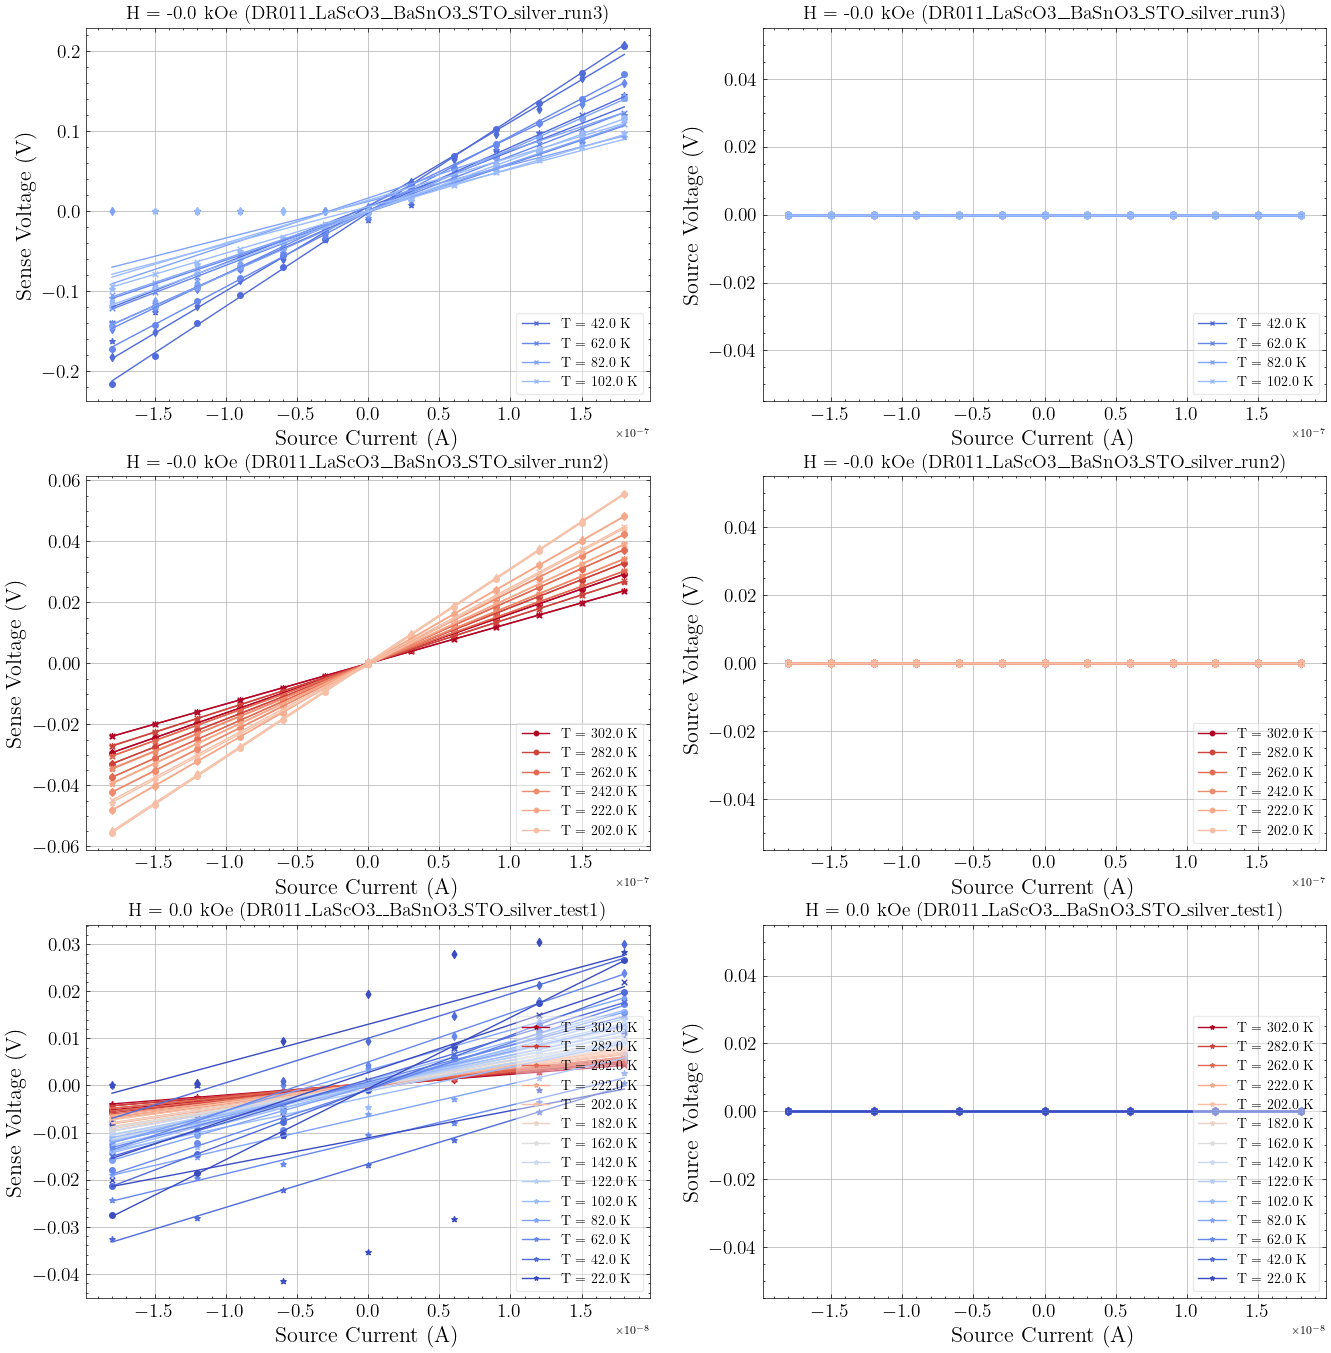

In [6]:
fig1 = plt.figure(figsize=(16, 5.5*len(dat)))
gs = fig1.add_gridspec(len(dat), 2)
labels = ['index_3', 'index_4', 'index_5', 'index_6']
color_s = ['r', 'g', 'b', 'm'] # simple four colors for the 4 configurations of vdp

# Loop over the data sets
for j, d in enumerate(dat):
    
    ax = fig1.add_subplot(gs[j, 0])
    ax1 = fig1.add_subplot(gs[j, 1])

    # Select the B field that you want to plot
    Bi = int( (d.ctf[5]/2)-1 )
    
    # Loop over the temperatures
    for Ti in range(d.ctf[4]):
        # Loop over the four index configurations
        for i in range(4):  
            
            ## Plotting Source(I) vs Sense(V) data
            R_test = linregress(d.data_np_nd[Ti, Bi, :, 2, 2+i], d.data_np_nd[Ti, Bi, :, 4, 2+i])
            ax.scatter(d.data_np_nd[Ti, Bi, :, 2, 2+i], d.data_np_nd[Ti, Bi, :, 4, 2+i], color=cmap_temp(norm_temp(d.ctf[1][Ti])), marker=mark_p[i])
            ax.plot(d.data_np_nd[Ti, Bi, :, 2, 2+i], R_test.intercept + R_test.slope * d.data_np_nd[Ti, Bi, :, 2, 2+i], color=cmap_temp(norm_temp(d.ctf[1][Ti])))
        
            ## Plotting Source(I) vs Source(V) data
            R_test_2 = linregress(d.data_np_nd[Ti, Bi, :, 2, 2+i], d.data_np_nd[Ti, Bi, :, 3, 2+i])
            ax1.scatter(d.data_np_nd[Ti, Bi, :, 2, 2+i], d.data_np_nd[Ti, Bi, :, 3, 2+i], color=cmap_temp(norm_temp(d.ctf[1][Ti])), marker=mark_p[i])
            ax1.plot(d.data_np_nd[Ti, Bi, :, 2, 2+i], R_test_2.intercept + R_test_2.slope * d.data_np_nd[Ti, Bi, :, 2, 2+i], color=cmap_temp(norm_temp(d.ctf[1][Ti])))
        
        
        # Add dummy plots for the legend entry
        ax.plot([], [], marker = mark_p[j], color=cmap_temp(norm_temp(d.ctf[1][Ti])), label=f'T = {d.ctf[1][Ti]} K')
        ax1.plot([], [], marker = mark_p[j], color=cmap_temp(norm_temp(d.ctf[1][Ti])), label=f'T = {d.ctf[1][Ti]} K')
        
    ax.legend(loc='lower right', fontsize=10, markerscale=0.8, framealpha=0.4)
    ax1.legend(loc='lower right', fontsize=10, markerscale=0.8, framealpha=0.4)
    
    # Set labels and title
    ax.set_xlabel('Source Current (A)', fontsize = 16)
    ax.set_ylabel('Sense Voltage (V)', fontsize = 16)
    ax.set_title(f'H = {np.round(d.data_np_nd[Ti, Bi, 0, 1, 2],decimals=0)*10} kOe ({d.plot_str})', fontsize=14)
        

    # Set labels and title
    ax1.set_xlabel('Source Current (A)', fontsize = 16)
    ax1.set_ylabel('Source Voltage (V)', fontsize = 16)
    ax1.set_title(f'H = {np.round(d.data_np_nd[Ti, Bi, 0, 1, 2],decimals=0)*10} kOe ({d.plot_str})', fontsize=14)

    ax.tick_params(axis='both', which='major', labelsize=14)  
    ax1.tick_params(axis='both', which='major', labelsize=14) 


    #ax.set_ylim(-1e-3,1e-3)
    #ax.set_ylim(4e-4,6e-4)

plt.show()
if export_data == True:
    fig1.savefig(dat[0].directory.joinpath(f'{dat[0].plot_str}_IV_resistivity.{fig_format}'), dpi=300, bbox_inches='tight', transparent=plot_transparency)


## R-squared Analysis to Check Linearity of I-V data

average R-squared for DR011_LaScO3__BaSnO3_STO_silver_run3 = 0.9660628416728372
average R-squared for DR011_LaScO3__BaSnO3_STO_silver_run2 = 0.9999931850322047
average R-squared for DR011_LaScO3__BaSnO3_STO_silver_test1 = 0.9792572655050503


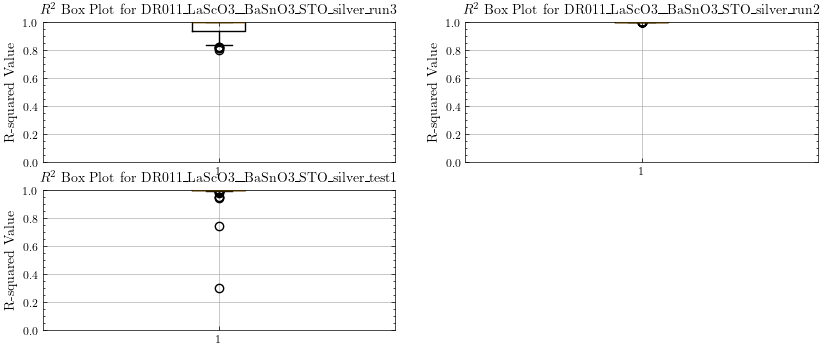

In [7]:
fig2 = plt.figure(figsize=(10, 3*len(dat) // 2))
gs = fig2.add_gridspec(1+len(dat) // 2, 2)

for j, d in enumerate(dat):
    #for i in range(len(d.R_squared_res)):
        #print(f'{d.filename}T={d.ctf[1][i//4]}, config = {i %4 } R-squared = {d.R_squared_res[i]}') - only works for zero field at the moment
    
    
    print(f'average R-squared for {d.filename} =', sum(d.R_squared_res) / len(d.R_squared_res))
    ax = fig2.add_subplot(gs[j // 2, j % 2])
    
    # Plot R-square values in a boxplot
    # Note that the y axis is showing the deviation in 1e-6 from the perfect value of 1 so generally the values are very close to 1
    ax.boxplot(d.R_squared_res)
    ax.set_title(f'$R^2$ Box Plot for {d.plot_str}')
    ax.set_ylabel('R-squared Value')
    ax.set_ylim(0, 1)  # If needed, you can set x-axis limits too

plt.show()

if export_data == True:
    fig2.savefig(dat[0].directory.joinpath(f'{dat[0].plot_str}_IV_Rsq_boxplot.{fig_format}'), dpi=300, bbox_inches='tight', transparent=plot_transparency)

## Resistivity Configuration Compararison 
Comparing the resistivity in configuration A and B which are inverted versions of one another (e.g. source meter and sense meter swapped positions)
This is a good check for any systematic errors

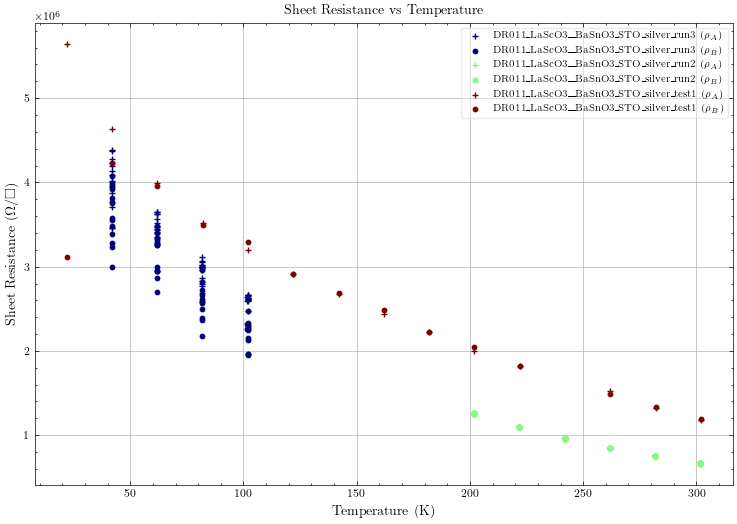

In [8]:
# Create a figure and axis
fig3 = plt.figure()
ax = fig3.add_subplot(111)  # Create a single subplot

c_val = plt.cm.jet(np.linspace(0,1,len(dat)))


# Loop over the data sets
for j, d in enumerate(dat):
    
    # Flatten the resistivity data
    res_data_flat = d.res_data.reshape((d.ctf[4]*d.ctf[5],6))  
    
    # Plot R_sheet_A vs Temp
    ax.scatter(res_data_flat[:,0], res_data_flat[:,2] * unit_scale, marker='+', color=c_val[j], label=f'{d.plot_str} ($\\rho_A$)')

    # Plot R_sheet_B vs Temp
    ax.scatter(res_data_flat[:,0], res_data_flat[:,3] * unit_scale, marker='o', s=10, color=c_val[j], label=f'{d.plot_str} ($\\rho_B$)')

# Set labels and title for either sheet resistance or resistivity
ax.set_xlabel('Temperature (K)')
if dat[0].film_thickness == 1:
    ax.set_ylabel(r'Sheet Resistance ($\Omega/\square$)')
    ax.set_title(r'Sheet Resistance vs Temperature')
    
elif ohm_m == 1:
    ax.set_ylabel(r'Resistivity ($\Omega \cdot$m)')
    ax.set_title(r'Resistivity vs Temperature')
    
else:
    ax.set_ylabel(r'Resistivity ($\mu \Omega \cdot$cm)')
    ax.set_title(r'Resistivity vs Temperature')



# Add a legend
ax.legend()

#ax.set_yscale('log')
#ax.set_ylim(2e4, 5e4)
#ax.set_xlim(0, 330)
# Show the plot


plt.show()

if export_data == True:
    fig3.savefig(dat[0].directory.joinpath(f'{dat[0].plot_str}_rho_xx_A_vs_B.{fig_format}'), dpi=300, bbox_inches='tight', transparent=plot_transparency)


## Resistivity vs Temperature

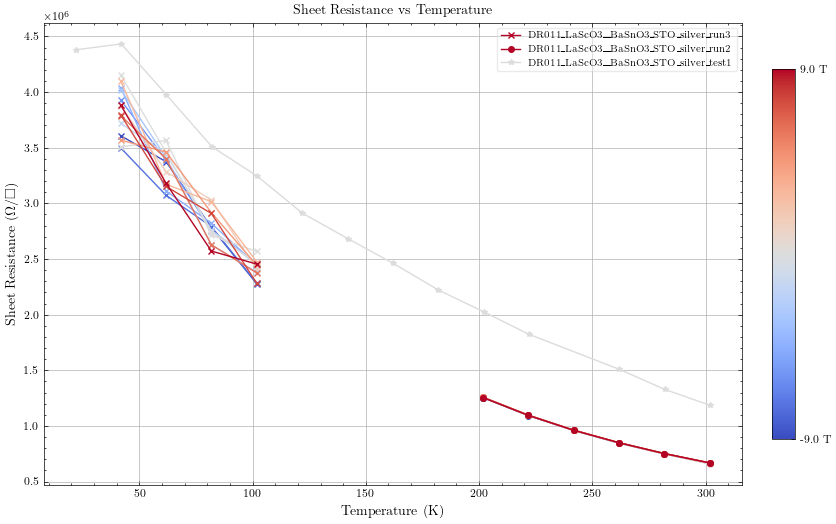

In [9]:
# Create a figure and GridSpec layout
fig4 = plt.figure(figsize= (fig_size[0] + fig_size[0]/9 , fig_size[1]) )
gs = gridspec.GridSpec(1, 2, width_ratios=[fig_size[0], fig_size[0]/9], wspace=0.0)

# Create the main plot
ax = fig4.add_subplot(gs[0])

# Add and adjust the colorbar using a custom function
sm = ScalarMappable(cmap=cmap_field, norm=norm_field)
add_colorbar(fig4, gs[1], sm, min_field, max_field, fig_size)


# Loop over the data sets
for j, d in enumerate(dat):
    # Loop over the B fields
    for Bi in range(d.ctf[5]):
        
        # Plot rho_film vs Temp
        ax.plot(d.res_data[:,Bi, 0], d.res_data[:,Bi, 4] * unit_scale, marker=mark_p[j], color=cmap_field(norm_field(d.res_data[0, Bi, 1])))

    # Add a dummy plot for the legend entry
    ax.plot([], [], marker = mark_p[j], color=cmap_field(norm_field(d.res_data[0, Bi, 1])), label=f'{d.plot_str}')
    
# Set labels and title for either sheet resistance or resistivity
ax.set_xlabel('Temperature (K)')
if dat[0].film_thickness == 1:
    ax.set_ylabel(r'Sheet Resistance ($\Omega/\square$)')
    ax.set_title(f'Sheet Resistance vs Temperature')
    
elif ohm_m == 1:
    ax.set_ylabel(r'Resistivity ($\Omega \cdot$m)')
    ax.set_title('Resistivity vs Temperature')
    
else:
    ax.set_ylabel(r'Resistivity ($\mu \Omega \cdot$cm)')
    ax.set_title('Resistivity vs Temperature')

# Add a legend
ax.legend()


#ax.set_xlim(0,3)
#ax.set_ylim(1e5, 4e6)
# ax.set_ylim(1e4, 1e5)
# ax.set_yscale('log')


# Show the plot
plt.show()

if export_data == True:
    fig4.savefig(dat[0].directory.joinpath(f'{dat[0].plot_str}_rho_xx_vs_temperature.{fig_format}'), dpi=300, bbox_inches='tight', transparent=plot_transparency)

- Anderson localisation causes the metal insulator transition at low T
- If you have defects in film, they can have an external effect of localising charge carriers and reducing the conductivity
    - Also causes loss of metalicity beneath a certain thicknes of LSMO etc
    -  Defects localise the previously delocalised charge carriers, either due to thickness reudction or low T
    - Low thicknes its because number of defects is constant - > higher defect density
    

## Resitivity vs Temperature for B=0 ONLY

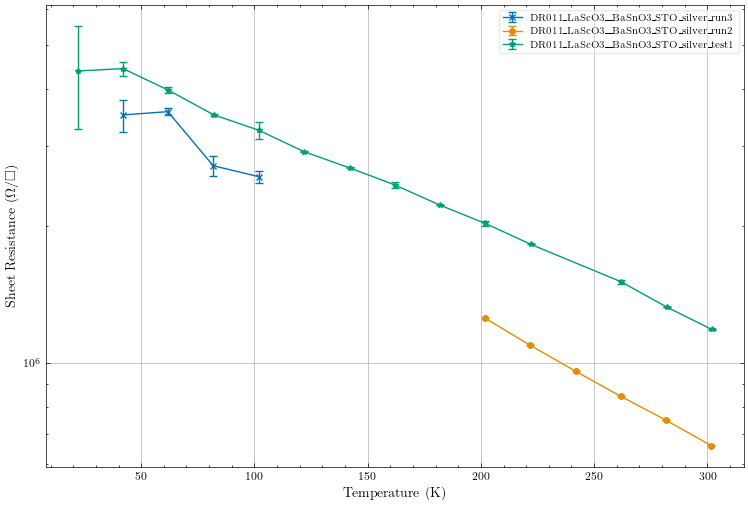

In [10]:
# Create a figure and axis
fig5 = plt.figure()
ax = fig5.add_subplot(111)  # Create a single subplot

# Loop over the data sets
for j, d in enumerate(dat):
    # Loop over a single B field
    for Bi in  [int(d.ctf[5]/2)]: 

        # Plot errorbar scaling the error by unit scale as well
        ax.errorbar(d.res_data[:, Bi, 0], d.res_data[:, Bi, 4] * unit_scale, yerr = d.res_data[:, Bi, 5] * unit_scale,fmt='-'+mark_p[j], capsize=3, label=f'{d.plot_str}')
      
    # Create a DataFrame with the x and y data
    #df = pd.DataFrame({'Temperature (K)': d.res_data[:, Bi, 0], 'Resistivity': d.res_data[:, Bi, 4] * unit_scale})
    # Write the DataFrame to an Excel file
    #df.to_excel(f'{d.filename}_data.xlsx', index=False)

# Set labels and title for either sheet resistance or resistivity
ax.set_xlabel('Temperature (K)')
if dat[0].film_thickness == 1:
    ax.set_ylabel(r'Sheet Resistance ($\Omega/\square$)')
    
elif ohm_m == 1:
    ax.set_ylabel(r'Resistivity ($\Omega \cdot$m)')
    
else:
    ax.set_ylabel(r'Resistivity ($\mu \Omega \cdot$cm)')

# Add a legend
ax.legend()

#ax.set_xlim(0,0.3)
#ax.set_ylim(1e5, 4e6)
#ax.set_ylim(136.4, 137)
ax.set_yscale('log')



# Show the plot
plt.show()

if export_data == True:
    fig5.savefig(dat[0].directory.joinpath(f'{dat[0].plot_str}_rho_xx_B0_vs_temperature.{fig_format}'), dpi=300, bbox_inches='tight', transparent=plot_transparency)

## Data Filtering on Resistivity Data
- There appear to be outliers where an error is thrown
- This is confirmed by repeat experiments where the spikes in resistivity are not consistent

## Resistivity vs H

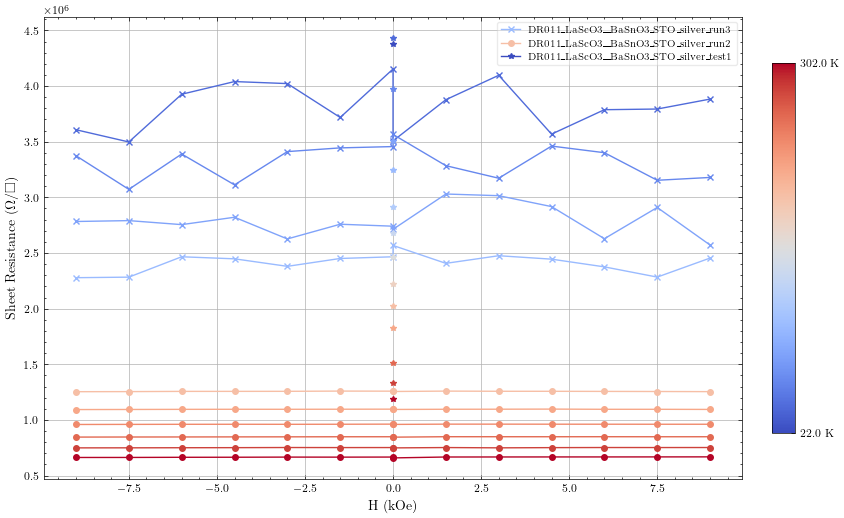

In [11]:
# Create a figure and GridSpec layout
fig6 = plt.figure(figsize= (fig_size[0] + fig_size[0]/9 , fig_size[1]) )
gs = gridspec.GridSpec(1, 2, width_ratios=[fig_size[0], fig_size[0]/9], wspace=0.0)

# Create the main plot
ax = fig6.add_subplot(gs[0])

# Add and adjust the colorbar using a custom function
sm = ScalarMappable(cmap=cmap_temp, norm=norm_temp)
add_colorbar(fig6, gs[1], sm, min_temp, max_temp, fig_size, field = False)




# Loop over the data sets
for j, d in enumerate(dat):
    # Loop over the temperatures
    for Ti, T in enumerate(d.ctf[1], start=0):      
            
            ax.plot(d.res_data[Ti, :, 1], d.res_data[Ti, :, 4] * unit_scale, marker=mark_p[j], color=cmap_temp(norm_temp(T)))
            #ax.plot(d.res_data[Ti, :, 1], d.res_data[Ti, :, 3] * unit_scale, marker=mark_p[j], color=cmap_temp(norm_temp(T)), linestyle=':')
    
    # Add a dummy plot for the legend entry
    ax.plot([], [], marker = mark_p[j], color=cmap_temp(norm_temp(T)), label=f'{d.plot_str}')
        
# Set labels and title for either sheet resistance or resistivity
ax.set_xlabel('H (kOe)')   
if dat[0].film_thickness == 1:
    ax.set_ylabel(r'Sheet Resistance ($\Omega/\square$)')
elif ohm_m == 1:
    ax.set_ylabel(r'Resistivity ($\Omega \cdot$m)')
    ax.set_title(r'Resistivity vs Field')
else:
    ax.set_ylabel(r'Resistivity ($\mu \Omega \cdot$cm)')
    ax.set_title(r'Resistivity vs Field')

ax.legend()


#ax.set_xlim(-0.0001, 0.0001)

plt.show()

if export_data == True:
    fig6.savefig(dat[0].directory.joinpath(f'{dat[0].plot_str}_resistivity_vs_field.{fig_format}'), dpi=300, bbox_inches='tight', transparent=plot_transparency)


## Magnetoresistance vs H
- Plotting the magnetoresistance vs the Applied field strength (H) for several temperatures

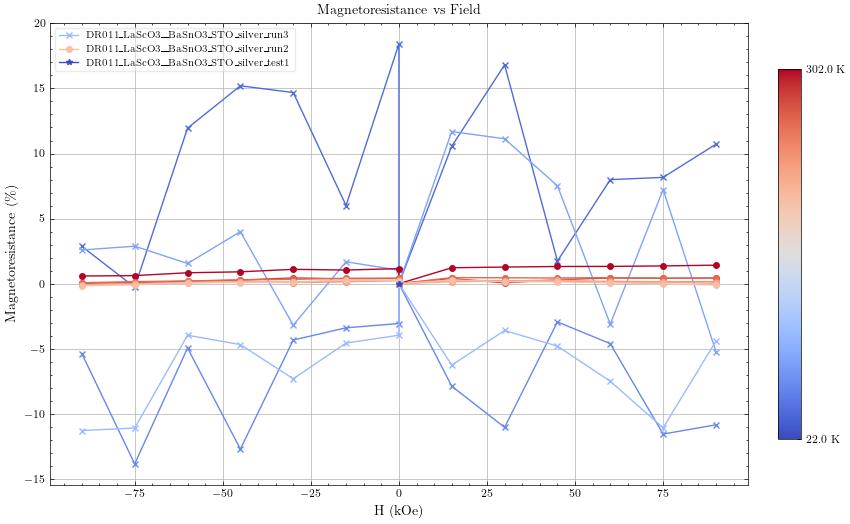

In [12]:
# Create a figure and GridSpec layout
fig7 = plt.figure(figsize= (fig_size[0] + fig_size[0]/9 , fig_size[1]) )
gs = gridspec.GridSpec(1, 2, width_ratios=[fig_size[0], fig_size[0]/9], wspace=0.0)

# Create the main plot
ax = fig7.add_subplot(gs[0])

# Add and adjust the colorbar using a custom function
sm = ScalarMappable(cmap=cmap_temp, norm=norm_temp)
add_colorbar(fig7, gs[1], sm, min_temp, max_temp, fig_size, field = False)


# Loop over the data sets
for j, d in enumerate(dat):
    # Loop over the temperatures
    for Ti, T in enumerate(d.ctf[1], start=0):  
            # Add a plot of magnetoresistance vs field strength for each loop of temperature (excluding last field point which is repeat of B=0)
            ax.plot(d.tf_av[Ti,:,1] * 10, d.mag_res[Ti, :, 2], marker=mark_p[j], color=cmap_temp(norm_temp(T)))
            #ax.plot(d.tf_av[Ti,:,1] * 10, d.mag_res[Ti, :, 1]-d.mag_res[Ti, :, 0], marker=mark_p[j], color=cmap_temp(norm_temp(T)), linestyle=':')
            
    # Add a dummy plot for the legend entry
    ax.plot([], [], marker = mark_p[j], color=cmap_temp(norm_temp(T)), label=f'{d.plot_str}')
    #ax.plot([], [], marker = mark_p[j], color=cmap_temp(norm_temp(T)), label=f'{d.filename}(configA-configB)', linestyle=':')
        
ax.set_xlabel('H (kOe)')
ax.set_ylabel(r'Magnetoresistance (\%)')
ax.set_title(f'Magnetoresistance vs Field')
ax.legend()

#ax.set_ylim(-8, 2)

plt.show()

if export_data == True:
    fig7.savefig(dat[0].directory.joinpath(f'{dat[0].plot_str}_magnetoresistance_vs_field.{fig_format}'), dpi=300, bbox_inches='tight', transparent=plot_transparency)

- The longitudinal resistance exhibits a rapid decrease, attributed to weak localization (WL), a phenomenon commonly observed in  disordered semiconductor systems
- The magnetoresistance (MR) exhibited a parabolic behavior within the intermediate magnetic field range (1.5T to 4T), as illustrated in Figure 5(b). Concurrently, at the fields where SdH oscillations emerge, it indicates the onset of quantum effects that dominate over the classical parabolic behavior.
-  weak localization effect manifests itself much more strongly in low-dimensional systems (films and wires)

## Magnetoresistance Vs T
- Now looking at how the Magnetoresitance at a set field strength varies over temperature
- Displaying this for VDP configuration A, VDP configuration B and the average of the two

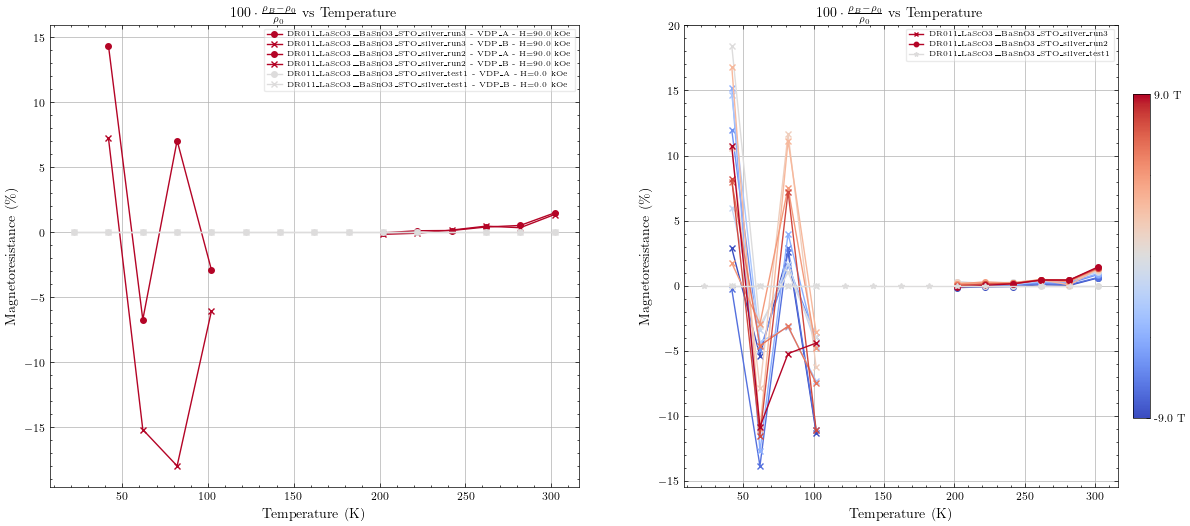

In [13]:
fig8 = plt.figure(figsize=(15, 6))
ax = fig8.add_subplot(121)  # Create two subplots
ax2 = fig8.add_subplot(122)  

# Sub_plot 1: Comparing configurations A and B
for j, d in enumerate(dat):
    
    #### Sub plot 1: Comparing the magnetoresistance vs T for configurations A vs B
    
    Bi_max = int(d.ctf[5])-1

    # Plot the magnetoresistance for the maximum positive field strength vs zero field
    ax.plot(d.ctf[1], d.mag_res[:, Bi_max, 0], marker='o', color=cmap_field(norm_field(d.ctf[2][Bi_max])), label=f'{d.plot_str} - VDP_A - H={np.round(d.ctf[2][Bi_max]*10, 0)} kOe')
    ax.plot(d.ctf[1], d.mag_res[:, Bi_max, 1], marker='x', color=cmap_field(norm_field(d.ctf[2][Bi_max])), label=f'{d.plot_str} - VDP_B - H={np.round(d.ctf[2][Bi_max]*10, 0)} kOe')


    #### Sub plot 2: Comparing the average magnetoresistance vs T for various field strengths 
    # Loop over the field values    
    for Bi, B in enumerate(d.ctf[2], start=0):
        ax2.plot(d.tf_av[:,Bi_max,0], d.mag_res[:, Bi, 2], marker=mark_p[j], color=cmap_field(norm_field(B)))     
    
    # Add a dummy plot for the legend entry
    ax2.plot([], [], marker = mark_p[j], color = cmap_field(norm_field(B)), label=f'{d.plot_str}')
    

ax.set_xlabel('Temperature (K)')
ax.set_ylabel(r'Magnetoresistance (\%)')
ax.set_title(r'$100 \cdot \frac{\rho_{B} - \rho_{0}}{\rho_{0}}$ vs Temperature')
ax.legend(loc='best', fontsize = 'xx-small', framealpha=0.4)
        
ax2.set_xlabel('Temperature (K)')
ax2.set_ylabel(r'Magnetoresistance (\%)')
ax2.set_title(r'$100 \cdot \frac{\rho_{B} - \rho_{0}}{\rho_{0}}$ vs Temperature')
# Add a legend outside the plot
ax2.legend(loc='best', fontsize='xx-small', markerscale=0.8, framealpha=0.4)

#ax2.set_ylim(-10, 100)
#ax2.set_xlim(0, 50)

# Create a ScalarMappable and add a colorbar
sm = ScalarMappable(cmap=cmap_field, norm=norm_field)
cbar = plt.colorbar(sm, ax=ax2,  pad=0.03, shrink=0.7)
cbar.set_ticks([min_field, max_field])
cbar.set_ticklabels([f'{min_field:.1f} T', f'{max_field:.1f} T'])


plt.show()

if export_data == True:
    fig8.savefig(dat[0].directory.joinpath(f'{dat[0].plot_str}_magnetoresistance_vs_temperature.{fig_format}'), dpi=300, bbox_inches='tight', transparent=plot_transparency)


## Arhenius Plot

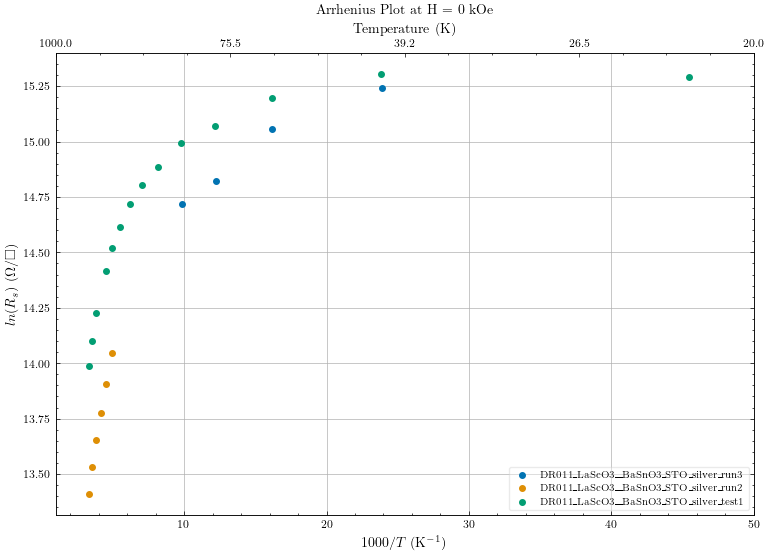

In [14]:
# Create a figure and axis
fig9 = plt.figure()
ax = fig9.add_subplot(111)  # Create a single subplot

# Loop over the data sets
for j, d in enumerate(dat):
    # Plot rho_film vs 1000/Temp
    Bi_zero = int(d.ctf[5]/2)-1
    ax.scatter(1000 / d.res_data[:, Bi_zero, 0], np.log(d.res_data[:, Bi_zero, 4]), marker='o', linestyle='-', label=f'{d.plot_str}')


# Set labels and title for either sheet resistance or resistivity
ax.set_xlabel(r'$1000/T$ (K$^{-1}$)')
ax.set_title(r'Arrhenius Plot at H = 0 kOe')
if dat[0].film_thickness == 1:
    ax.set_ylabel(r'$ln(R_s)$ ($\Omega/\square$)')
else:
    ax.set_ylabel(r'$\ln(\rho)$ ($\Omega \cdot m$)')


# Add a legend
ax.legend()

# Create a secondary x-axis at the top
ax2 = ax.twiny()

ax.set_xlim(1, 50)

# Set the limits of the secondary x-axis to match the primary x-axis
ax2.set_xlim(ax.get_xlim())

# Set the ticks and labels for the secondary x-axis
new_ticks = np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], num=5)
ax2.set_xticks(new_ticks)
ax2.set_xticklabels([f'{1000/tick:.1f}' for tick in new_ticks])
ax2.set_xlabel('Temperature (K)')
# Disable grid lines for the secondary x-axis
ax2.grid(False)



# Show the plot
plt.show()

if export_data == True:
    fig9.savefig(dat[0].directory.joinpath(f'{dat[0].plot_str}_Arrhenius Plot.{fig_format}'), dpi=300, bbox_inches='tight', transparent=plot_transparency)

## Log(R) vs Log(T)

$7.29T^3$ - $40.05T^2$ + $72.48T$ - 36.68
- $2.59T^3$ + $17.58T^2$ - $41.18T$ + 39.35
- $0.35T^3$ + $1.39T^2$ - $1.89T$ + 7.52


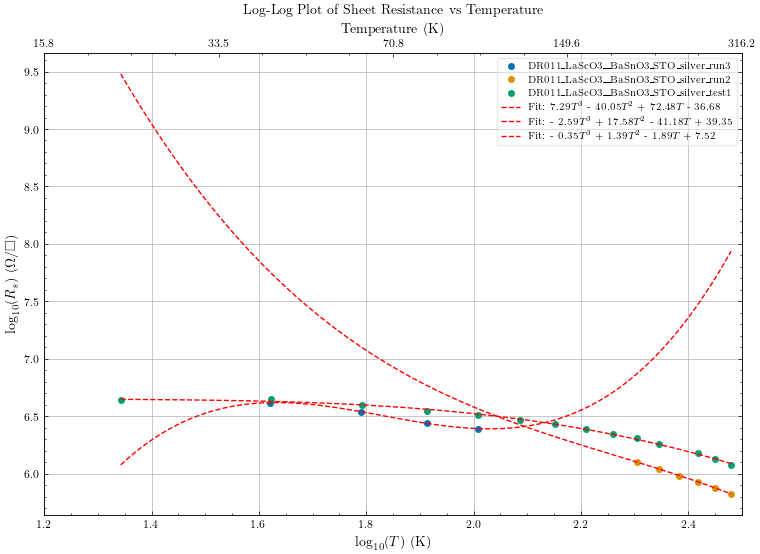

In [15]:
# Create a figure and axis
fig10 = plt.figure()
ax = fig10.add_subplot(111)  # Create a single subplot

# Loop over the data sets
for j, d in enumerate(dat):
    # Plot log10(rho_film) vs log10(Temp)
    Bi_zero = int(d.ctf[5]/2)-1
    ax.scatter(np.log10(d.res_data[:, Bi_zero, 0]), np.log10(d.res_data[:, Bi_zero, 4]), marker='o', linestyle='-', label=f'{d.plot_str}')

# Set labels and title for either sheet resistance or resistivity
ax.set_xlabel(r'$\log_{10}(T)$ (K)')
ax.set_title(r'Arrhenius Plot at H = 0 kOe')
if dat[0].film_thickness == 1:
    ax.set_ylabel(r'$\log_{10}(R_s)$ ($\Omega/ \square$)')
    ax.set_title(r'Log-Log Plot of Sheet Resistance vs Temperature')
else:
    ax.set_ylabel(r'$\log_{10}(\rho)$ ($\Omega \cdot m$)')
    ax.set_title(r'Log-Log Plot of Resistivity vs Temperature')



# Fit to polynomial
x_vals = np.linspace(np.log10(min_temp), np.log10(max_temp), 100)
for j, d in enumerate(dat):
    Bi_zero = int(d.ctf[5]/2)-1
    log_T = np.log10(d.res_data[:, Bi_zero, 0])
    log_R = np.log10(d.res_data[:, Bi_zero, 4])
    
    # Change polynomial order as needed (1 for linear, 2 for quadratic, 3 for cubic, etc.)
    poly_order = 3
    coeffs = np.polyfit(log_T, log_R, poly_order)
    
    # Convert to readable equation string
    equation = poly_to_string(coeffs)
    print(str(equation))
    
    # Plot with equation in label
    ax.plot(x_vals, np.polyval(coeffs, x_vals), 
            label=f'Fit: {str(equation)}', 
            linestyle='--', color='r')
# Add a legend
ax.legend()

# Create a secondary x-axis at the top
ax2 = ax.twiny()

ax.set_xlim(1.2, 2.5)

# Set the limits of the secondary x-axis to match the primary x-axis
ax2.set_xlim(ax.get_xlim())

# Set the ticks and labels for the secondary x-axis
log_ticks = np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], num=5)
ax2.set_xticks(log_ticks)
ax2.set_xticklabels([f'{10**tick:.1f}' for tick in log_ticks])
ax2.set_xlabel('Temperature (K)')

# Disable grid lines for the secondary x-axis
ax2.grid(False)

# Show the plot
plt.show()

if export_data == True:
    fig10.savefig(dat[0].directory.joinpath(f'{dat[0].plot_str}_LogR_vs_LogT.{fig_format}'), dpi=300, bbox_inches='tight', transparent=plot_transparency)

## Plot IV Data to check linearity of Hall measurements

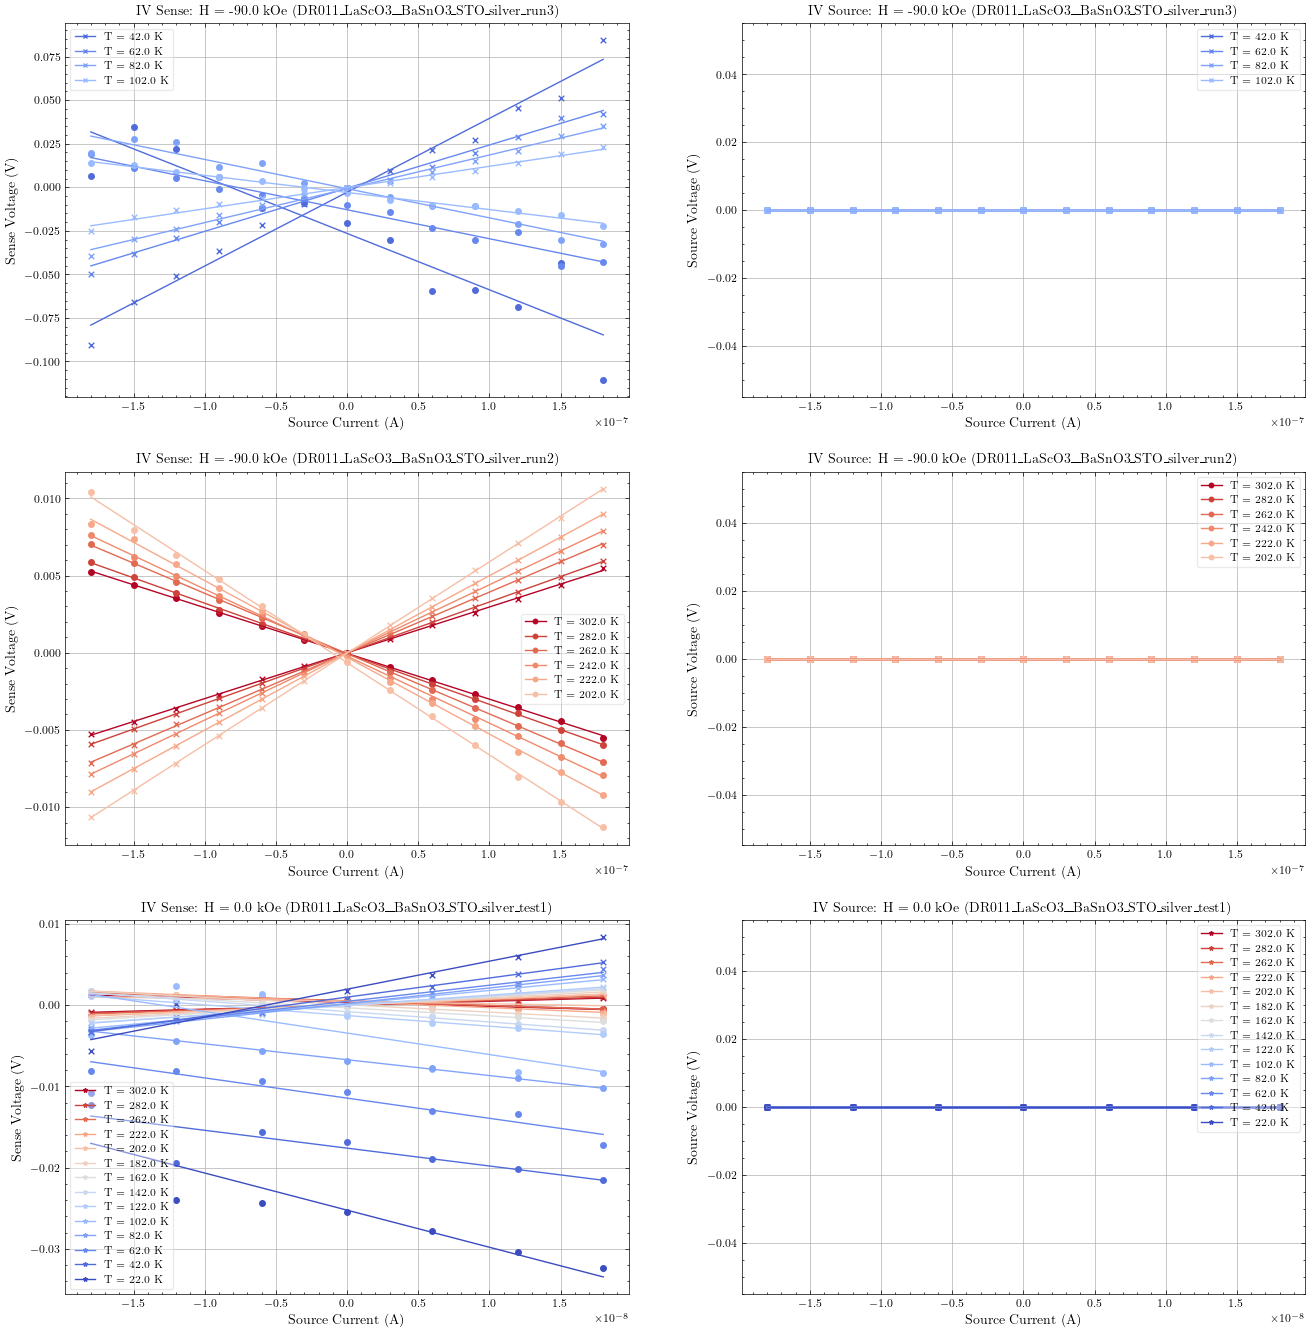

In [16]:
fig11 = plt.figure(figsize=(16, 5.5*len(dat)))
gs = fig11.add_gridspec(len(dat), 2)
labels = ['index_1', 'index_2']
color_s = ['r', 'g', 'b', 'm'] # simple four colors for the 4 configurations of vdp

for j, d in enumerate(dat):
    
    ax = fig11.add_subplot(gs[j, 0])
    ax1 = fig11.add_subplot(gs[j, 1])

    # Select the B field that you want to plot
    Bi = int( (d.ctf[5]/2)-1 )
    
    # Loop over the temperatures
    for Ti in range(d.ctf[4]):
        # Loop over the two hall index configurations
        for i in range(2):  
            
            ## Plotting Source(I) vs Sense(V) data
            R_test = linregress(d.data_np_nd[Ti, Bi, :, 2, i], d.data_np_nd[Ti, Bi, :, 4, i])
            ax.scatter(d.data_np_nd[Ti, Bi, :, 2, i], d.data_np_nd[Ti, Bi, :, 4, i], color=cmap_temp(norm_temp(d.ctf[1][Ti])), marker=mark_p[i])
            ax.plot(d.data_np_nd[Ti, Bi, :, 2, i], R_test.intercept + R_test.slope * d.data_np_nd[Ti, Bi, :, 2, i], color=cmap_temp(norm_temp(d.ctf[1][Ti])))

            ## plotting the Source(I) vs Source(V) data
            R_test_2 = linregress(d.data_np_nd[Ti, Bi, :, 2, i], d.data_np_nd[Ti, Bi, :, 3, i])
            ax1.scatter(d.data_np_nd[Ti, Bi, :, 2, i], d.data_np_nd[Ti, Bi, :, 3, i], color=cmap_temp(norm_temp(d.ctf[1][Ti])), marker=mark_p[i])
            ax1.plot(d.data_np_nd[Ti, Bi, :, 2, i], R_test_2.intercept + R_test_2.slope * d.data_np_nd[Ti, Bi, :, 2, i], color=cmap_temp(norm_temp(d.ctf[1][Ti])))
    
        # Add a dummy plot for the legend entry
        ax.plot([], [], marker = mark_p[j], color=cmap_temp(norm_temp(d.ctf[1][Ti])), label=f'T = {d.ctf[1][Ti]} K')
        ax1.plot([], [], marker = mark_p[j], color=cmap_temp(norm_temp(d.ctf[1][Ti])), label=f'T = {d.ctf[1][Ti]} K')
        
    ax.legend(loc='best', fontsize='small', markerscale=0.8, framealpha=0.4)
    ax1.legend(loc='best', fontsize='small', markerscale=0.8, framealpha=0.4)
        
        
    # Set labels and title
    ax.set_xlabel('Source Current (A)')
    ax.set_ylabel('Sense Voltage (V)')
    ax.set_title(f'IV Sense: H = {np.round(d.data_np[0, 1, 2],decimals=0)*10} kOe ({d.plot_str})')
    
    ax1.set_xlabel('Source Current (A)')
    ax1.set_ylabel('Source Voltage (V)')
    ax1.set_title(f'IV Source: H = {np.round(d.data_np[0, 1, 2],decimals=0)*10} kOe ({d.plot_str})')

    #ax.set_ylim(-0.00005,0.00005)

plt.show()

if export_data == True:
    fig11.savefig(dat[0].directory.joinpath(f'{dat[0].plot_str}_IV_resistivity.{fig_format}'), dpi=300, bbox_inches='tight', transparent=plot_transparency)


## R-squared Analysis to Check Linearity of Hall I-V data

average R-squared_A for DR011_LaScO3__BaSnO3_STO_silver_run3 = 0.9813133614976678
average R-squared_B for DR011_LaScO3__BaSnO3_STO_silver_run3 = 0.9498836358624579


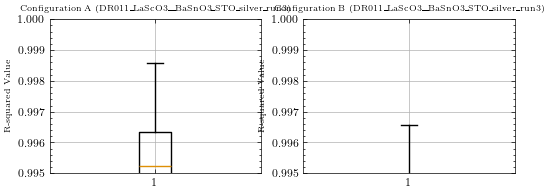

average R-squared_A for DR011_LaScO3__BaSnO3_STO_silver_run2 = 0.9999370157588127
average R-squared_B for DR011_LaScO3__BaSnO3_STO_silver_run2 = 0.9996271147719514


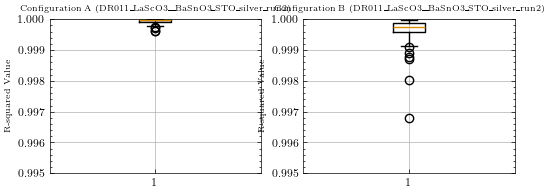

average R-squared_A for DR011_LaScO3__BaSnO3_STO_silver_test1 = 0.9960738190455283
average R-squared_B for DR011_LaScO3__BaSnO3_STO_silver_test1 = 0.9031085047415469


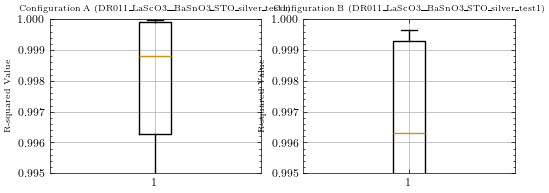

In [17]:
for d in dat:
    hall_data_flat = np.copy(d.hall_data).reshape((d.ctf[4]*d.ctf[5], 7))
    
    print(f'average R-squared_A for {d.filename} =', np.mean(np.abs(hall_data_flat[:, 3])))
    print(f'average R-squared_B for {d.filename} =', np.mean(np.abs(hall_data_flat[:, 5])))

    # Plot R-square values in a boxplot
    # Note that the y axis is showing the deviation in 1e-6 from the perfect value of 1 so generally the values are very close to 1
    fig12 = plt.figure(figsize=(6, 2))
    ax = fig12.add_subplot(121)
    ax.boxplot(np.abs(hall_data_flat[:, 3]))
    ax.set_title(f'Configuration A ({d.plot_str})', fontsize=6)
    ax.set_ylabel('R-squared Value', fontsize=6)
    ax.set_ylim(1-5e-3, 1)  # If needed, you can set x-axis limits too

    ax2 = fig12.add_subplot(122)
    ax2.boxplot(np.abs(hall_data_flat[:, 5]))
    ax2.set_title(f'Configuration B ({d.plot_str})', fontsize=6)
    ax2.set_ylabel('R-squared Value', fontsize=6)
    ax2.set_ylim(1-5e-3, 1)  # If needed, you can set x-axis limits too
    plt.show()

    if export_data == True:
        fig12.savefig(dat[0].directory.joinpath(f'{dat[0].plot_str}_R_squared_hall_res.{fig_format}'), dpi=300, bbox_inches='tight', transparent=plot_transparency)


## Hall Resistivity ($\rho_{xy}$)
- This is: $\rho_{xy} = \frac{V_{measured-perpendicular}}{I_{source}}*t$
- Define: $Rsheet_{xy} = \frac{V_{measured-perpendicular}}{I_{source}}$ = $\frac{\rho_{xy}}{t}$


## Hall resisitivity vs Temperature

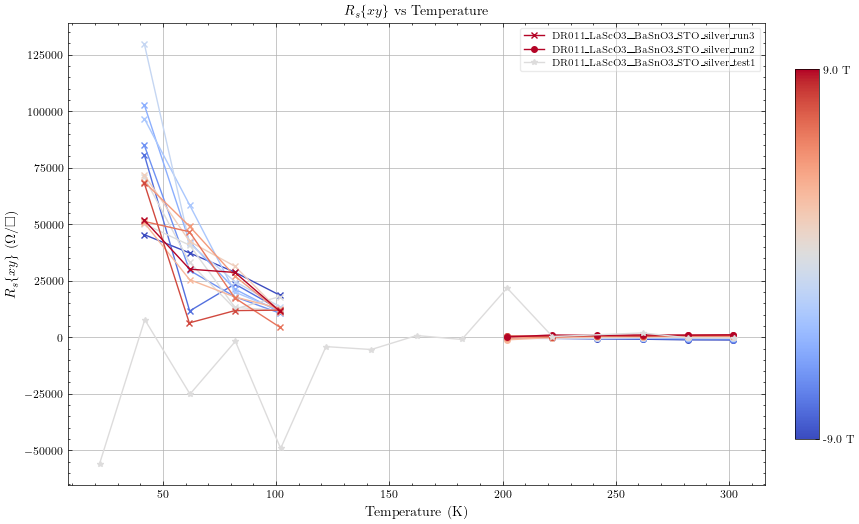

In [18]:
# Create a figure and GridSpec layout
fig13 = plt.figure(figsize= (fig_size[0] + fig_size[0]/9 , fig_size[1]) )
gs = gridspec.GridSpec(1, 2, width_ratios=[fig_size[0], fig_size[0]/9], wspace=0.0)

# Create the main plot
ax = fig13.add_subplot(gs[0])

# Add and adjust the colorbar using a custom function
sm = ScalarMappable(cmap=cmap_field, norm=norm_field)
add_colorbar(fig13, gs[1], sm, min_field, max_field, fig_size)

# Loop over the data sets
for j, d in enumerate(dat):
    # Loop over the B fields
    for Bi in range(d.ctf[5]):
        # Plot rho_film vs Temp
        ax.plot(d.hall_data[:, Bi, 0], d.hall_data[:, Bi, 6] * unit_scale, marker=mark_p[j], color= cmap_field(norm_field(d.hall_data[0, Bi, 1])))

    # Add a dummy plot for the legend entry
    ax.plot([], [], marker = mark_p[j], color = cmap_field(norm_field(d.hall_data[0, Bi, 1])), label=f'{d.plot_str}')
        
        
# Set labels and title for either sheet resistance or resistivity
ax.set_xlabel('Temperature (K)')
if dat[0].film_thickness == 1:

    ax.set_ylabel(r'$R_{s}\{xy\}$ ($\Omega/\square$)')
    ax.set_title(r'$R_{s}\{xy\}$ vs Temperature')

elif ohm_m == 1:
    ax.set_ylabel(r'Resistivity ($\Omega \cdot$m)')
    ax.set_title(r'$\rho_{xy}$ vs Temperature')

else:
    ax.set_ylabel(r'$\rho_{xy}\,(\mu \Omega \cdot cm)$')
    ax.set_title(r'$\rho_{xy}$ vs Temperature')
# Set labels and title


# ax.set_xlim(0,100)
# ax.set_ylim(1425,1525)

# Add a legend
ax.legend()

# Show the plot
#ax.set_ylim(-500,500)
plt.show()

if export_data == True:
    fig13.savefig(dat[0].directory.joinpath(f'{dat[0].plot_str}_rho_xy_vs_T.{fig_format}'), dpi=300, bbox_inches='tight', transparent=plot_transparency)


## Hall Resistivity vs Field

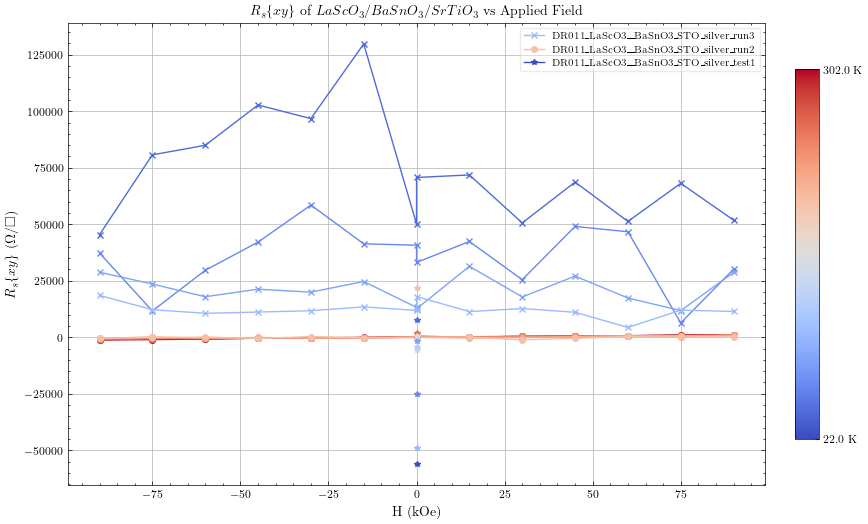

In [19]:
# Create a figure and GridSpec layout
fig14 = plt.figure(figsize= (fig_size[0] + fig_size[0]/9 , fig_size[1]) )
gs = gridspec.GridSpec(1, 2, width_ratios=[fig_size[0], fig_size[0]/9], wspace=0.0)

# Create the main plot
ax = fig14.add_subplot(gs[0])

# Add and adjust the colorbar using a custom function
sm = ScalarMappable(cmap=cmap_temp, norm=norm_temp)
add_colorbar(fig14, gs[1], sm, min_temp, max_temp, fig_size, field = False)


# Loop over the data sets
for j, d in enumerate(dat):

    for Ti, T in enumerate(d.ctf[1], start=0):

        # Plot rho_film vs Temp
        ax.plot(d.hall_data[Ti, :, 1]*10, d.hall_data[Ti, :, 6]*unit_scale, marker=mark_p[j], color=cmap_temp(norm_temp(T)))
        
    # Add a dummy plot for the legend entry
    ax.plot([], [], marker = mark_p[j], color = cmap_temp(norm_temp(T)), label=f'{d.plot_str}')


# Set labels and title for either sheet resistance or resistivity
ax.set_xlabel('H (kOe)')
if dat[0].film_thickness == 1:

    ax.set_ylabel(r'$R_{s}\{xy\}$ ($\Omega/\square$)')
    ax.set_title(r'$R_{s}\{xy\}$' f' of {d.material} vs Applied Field')
    
elif ohm_m == 1:
    ax.set_ylabel(r'$\rho_{xy}\, ($\Omega \cdot$m)')
    ax.set_title(r'$\rho_{xy}$' f' of {d.material} vs Applied Field')
    
else:
    ax.set_ylabel(r'$\rho_{xy}\,(\mu \Omega \cdot cm)$')
    ax.set_title(r'$\rho_{xy}$' f' of {d.material} vs Applied Field')
    


# Add a legend
ax.legend()

#ax.set_ylim(-30,30)
# Show the plot
plt.show()

if export_data == True:
    fig14.savefig(dat[0].directory.joinpath(f'{dat[0].plot_str}_rho_xy_vs_field.{fig_format}'), dpi=300, bbox_inches='tight', transparent=plot_transparency)


## Hall Resistivity vs Field Configuration A vs B
- Dotted line vs solid line is B vs A

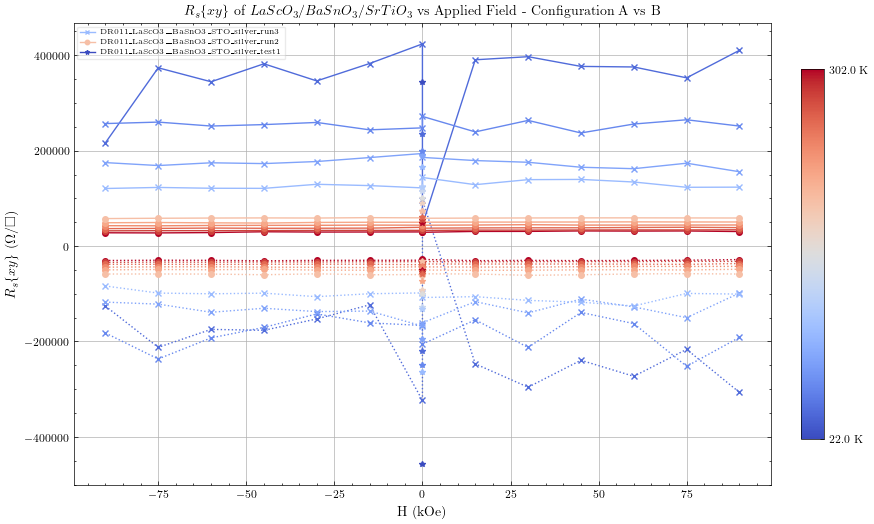

In [20]:
# Create a figure and GridSpec layout
fig15 = plt.figure(figsize= (fig_size[0] + fig_size[0]/9 , fig_size[1]) )
gs = gridspec.GridSpec(1, 2, width_ratios=[fig_size[0], fig_size[0]/9], wspace=0.0)

# Create the main plot
ax = fig15.add_subplot(gs[0])

# Add and adjust the colorbar using a custom function
sm = ScalarMappable(cmap=cmap_temp, norm=norm_temp)
add_colorbar(fig15, gs[1], sm, min_temp, max_temp, fig_size, field = False)

# Create a secondary y-axis
#ax2 = ax.twinx()

# Loop over the data sets
for j, d in enumerate(dat, start=0):
    # Loop over the temperatures
    for Ti, T in enumerate(d.ctf[1], start=0):
        # Plot rho_film vs Temp
        ax.plot(d.hall_data[Ti, :, 1]*10, (d.hall_data[Ti, :, 2])*unit_scale, marker=mark_p[j], color=cmap_temp(norm_temp(T)))
        ax.plot(d.hall_data[Ti, :, 1]*10, (d.hall_data[Ti, :, 4])*unit_scale, marker=mark_p[j], color=cmap_temp(norm_temp(T)), linestyle=':')
        
        #ax2.plot(d.ctf[2][:] * 10, d.mag_res[t_count, :, 2], color=cmap_temp(norm_temp(t)), linestyle=':')
    # Add a dummy plot for the legend entry
    ax.plot([], [], marker = mark_p[j], color = cmap_temp(norm_temp(T)), label=f'{d.plot_str}')


# Set labels and title for either sheet resistance or resistivity
ax.set_xlabel('H (kOe)')
if dat[0].film_thickness == 1:

    ax.set_ylabel(r'$R_{s}\{xy\}$ ($\Omega/\square$)')
    ax.set_title(r'$R_{s}\{xy\}$' f' of {d.material} vs Applied Field - Configuration A vs B')
    
elif ohm_m == 1:
    ax.set_ylabel(r'Resistivity ($\Omega \cdot$m)')
    ax.set_title(r'$\rho_{xy}$' f' of {d.material} vs Applied Field - Configuration A vs B')
    
else:
    ax.set_ylabel(r'$\rho_{xy}\,(\mu \Omega \cdot cm)$')
    ax.set_title(r'$\rho_{xy}$' f' of {d.material} vs Applied Field - Configuration A vs B')
    

# Add a legend
ax.legend(loc='best', framealpha=0.4, markerscale=0.8, fontsize='xx-small')


#ax.set_ylim(-200, 200)

# Show the plot
plt.show()

if export_data == True:
    fig15.savefig(dat[0].directory.joinpath(f'{dat[0].plot_str}_rho_xy_vs_field_AvsB.{fig_format}'), dpi=300, bbox_inches='tight', transparent=plot_transparency)


## Hall Resistivity ($\rho_{xy}$)
- This is: $\rho_{xy} = \frac{V_{measured-perpendicular}}{I_{source}}*t = \frac{B}{n\times e}$
- Or $Rsheet_{xy} = \frac{V_{measured-perpendicular}}{I_{source}}$ = $\frac{\rho_{xy}}{t}$

#### Step 1
- $V_H = \frac{I\times B}{n\times e\times t}$
- $V_H = (\frac{\rho_{xy}}{t})\times I = M_1\times I$ 
- $M_1$ (first gradient) = $\frac{\rho_{xy}}{t}$

#### Step 2
- $\rho_{xy} = \frac{1}{n\times e}\times B = M_2*B$
- $M_2 = R_H = \frac{1}{n\times e}$ = gradient of $\rho_{xy}$ vs B
- $n = \frac{1}{M_2 \times e} = \frac{1}{R_H \times e}$
- $\mu = \frac{1}{n\times e \times \rho_{xy}} = \frac{M_2}{\rho_{xy}} = \frac{R_H}{ \rho_{xy}}$

## 2DEG Case
- no longer inputting a t as it is unphysical
- $R_{sheet} = \frac{\rho_{xy}}{t}$
- $n_{2D} = n\times t$

#### Step 1
- $V_H = \frac{I\times B}{n\times e\times t}$
- $V_H = (\frac{\rho_{xy}}{t})\times I = M_1\times I$ 
- $M_1$ (first gradient) = $\frac{\rho_{xy}}{t}$

#### Step 2
- $\rho_{xy} = \frac{1}{n\times e}\times B$ ---> $M_1 = \frac{\rho_{xy}}{t} = \frac{1}{n\times e \times t}\times B = M_2*B$
- $M_2 = \frac{R_H}{t} = \frac{1}{n\times e \times t}$ 
- $n_{2D} = n\times t = \frac{1}{M_2 \times e} = \frac{1}{R_H \times e}$
- $\mu = \frac{1}{n\times e \times \rho_{xy}} = \frac{1}{\frac{n_{2d}}{t}\times e \times (\R_{sheet}\times t)} = \frac{1}{n_{2d}\times e \times \R_{sheet}} = \frac{M_2}{\R_{sheet}} = \frac{R_H}{ \rho_{xy}}$

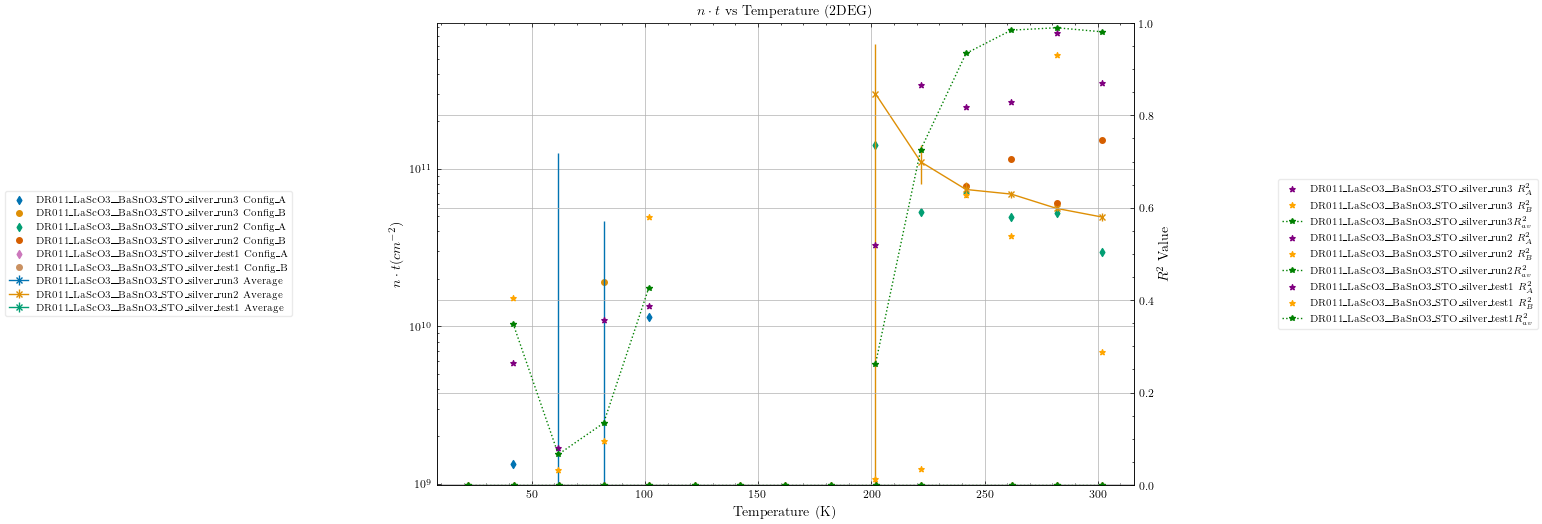

In [21]:
# Create a figure and axis
fig16 = plt.figure()
# Create a single subplot
ax = fig16.add_subplot(111)  
# Create a second y-axis on the right
ax2 = ax.twinx()

# Create separate marker arrays for positive and negative fields stitched together
marker_hall = ['x', 'o', '*']


for j, d in enumerate(dat):
    
    # Plot the charge carrier density on the right y-axis
    ax.scatter(d.hall_coefficient[:, 0], 1e-6 * np.divide(1, np.multiply(d.hall_coefficient[:, 1], scipy.constants.e)), marker='d', label=f'{d.plot_str} Config_A')
    ax.scatter(d.hall_coefficient[:, 0], 1e-6 * np.divide(1, np.multiply(d.hall_coefficient[:, 3], scipy.constants.e)), marker='o', label=f'{d.plot_str} Config_B')
    ax.errorbar(d.hall_coefficient[:, 0], d.hall_coefficient[:, 7],yerr = d.hall_coefficient[:, 8], fmt='-x', label=f'{d.plot_str} Average')
    # 1e-6 to convert from m^-3 to cm^-3
    
    # Plot the R^2 values on the left y-axis
    ax2.scatter(d.hall_coefficient[:, 0], np.abs(d.hall_coefficient[:, 2]), color='purple', marker='*', label=f'{d.plot_str} $R^2_A$')
    ax2.scatter(d.hall_coefficient[:, 0], np.abs(d.hall_coefficient[:, 4]), color='orange', marker='*', label=f'{d.plot_str} $R^2_B$')
    ax2.plot(d.hall_coefficient[:, 0], np.abs(d.hall_coefficient[:, 6]), color='green', marker='*', linestyle = ':', label=f'{d.plot_str}' r'$R^2_{av}$')
    

# Set labels and title for either sheet resistance or resistivity
ax.set_xlabel('Temperature (K)')
if dat[0].film_thickness == 1:
    ax.set_ylabel(r'$n\cdot t$' r'($cm^{-2}$)')
    ax.set_title(r'$n\cdot t$ vs Temperature (2DEG)')
else:
    ax.set_ylabel(r'n($cm^{-3}$)')
    ax.set_title(r'Charge Carrier Density vs Temperature')  

ax2.set_ylabel('$R^2$ Value')


# Add legends
ax.legend(loc='center right', bbox_to_anchor=(-0.2, 0.5), framealpha=0.4)
ax2.legend( loc='center left', bbox_to_anchor=(1.2, 0.5), framealpha=0.4)

# Set the R^2 limits between 0 and 1
ax2.set_ylim(0, 1)

#ax.set_ylim(0,5e28)
ax.set_yscale('log')

# Show the plot
plt.show()

if export_data == True:
    fig16.savefig(dat[0].directory.joinpath(f'{dat[0].plot_str}_n_vs_temperature.{fig_format}'), dpi=300, bbox_inches='tight', transparent=plot_transparency)


## Mobility vs T

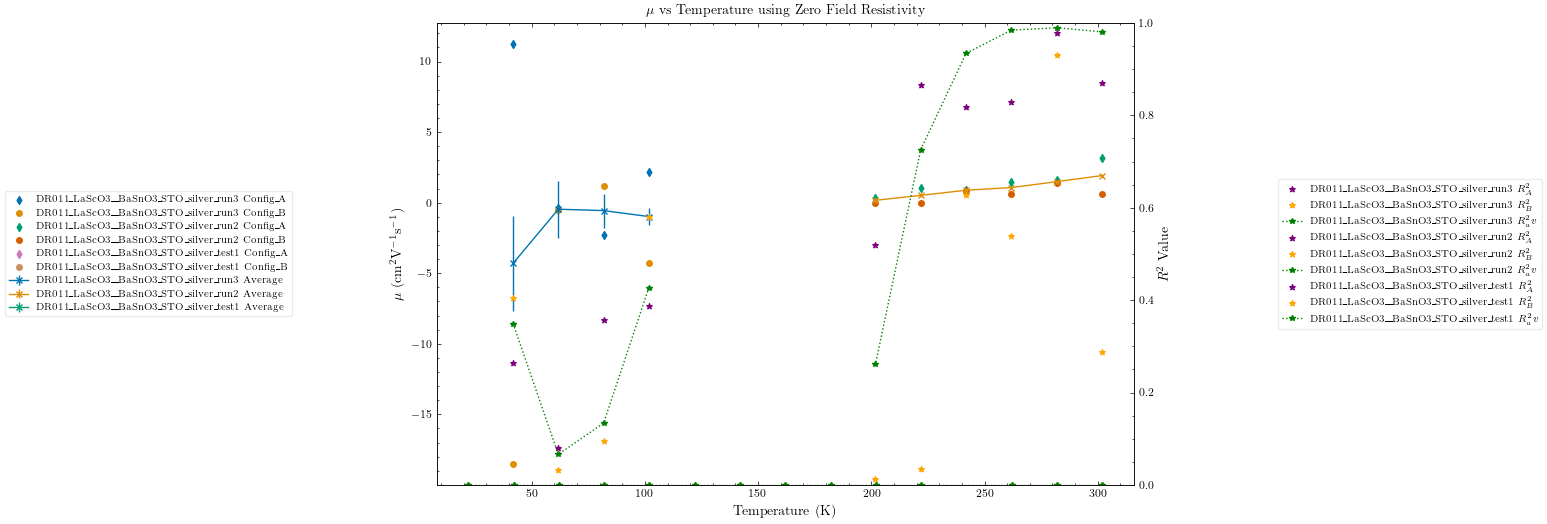

In [22]:
# Create a figure and axis
fig17 = plt.figure()
ax = fig17.add_subplot(111)  # Create a single subplot
# Create a second y-axis on the right
ax2 = ax.twinx()



# Loop over the data sets
for j, d in enumerate(dat, start=0):
    # Calculate index of the zero field data
    Bi_zero = int(d.ctf[5]/2)-1 

    # Plot the mobility on the left y-axis
    ax.scatter(d.hall_coefficient[:, 0], 1e4 * np.divide(d.hall_coefficient[:, 1], d.res_data[:, Bi_zero, 4]), marker='d',  label=f'{d.plot_str} Config_A')
    ax.scatter(d.hall_coefficient[:, 0], 1e4 * np.divide(d.hall_coefficient[:, 3], d.res_data[:, Bi_zero, 4]), marker='o', label=f'{d.plot_str} Config_B')
    ax.errorbar(d.hall_coefficient[:, 0], d.hall_coefficient[:, 9],yerr = d.hall_coefficient[:, 10], fmt='-x', label=f'{d.plot_str} Average')

    # Plot R^2 values on the right y-axis
    ax2.scatter(d.hall_coefficient[:, 0], np.abs(d.hall_coefficient[:, 2]), color='purple', marker='*', label=f'{d.plot_str} $R^2_A$')
    ax2.scatter(d.hall_coefficient[:, 0], np.abs(d.hall_coefficient[:, 4]), color='orange', marker='*', label=f'{d.plot_str} $R^2_B$')
    ax2.plot(d.hall_coefficient[:, 0], np.abs(d.hall_coefficient[:, 6]), color='green', marker='*', linestyle = ':', label=f'{d.plot_str} $R^2_av$')
    
# Set labels and title for the axis
ax.set_xlabel('Temperature (K)')
ax.set_ylabel(r'$\mu$ (cm$^2$V$^{-1}$s$^{-1}$)')
ax.set_title(r'$\mu$' f' vs Temperature using Zero Field Resistivity')
ax2.set_ylabel('$R^2$ Value')

ax.grid(False)
ax2.grid(False)

# Set the R^2 limits between 0 and 1
ax2.set_ylim(0, 1)

# Add legends
ax.legend(loc='center right', bbox_to_anchor=(-0.2, 0.5), framealpha=0.4)
ax2.legend(loc='center left', bbox_to_anchor=(1.2, 0.5), framealpha=0.4)

#ax.set_xlim(0,20)
#ax.set_yscale('log')

# Show the plot
plt.show()

if export_data == True:
    fig17.savefig(dat[0].directory.joinpath(f'{dat[0].plot_str}_mobility_vs_temperature.{fig_format}'), dpi=300, bbox_inches='tight', transparent=plot_transparency)


## Charge Carrier Density Only

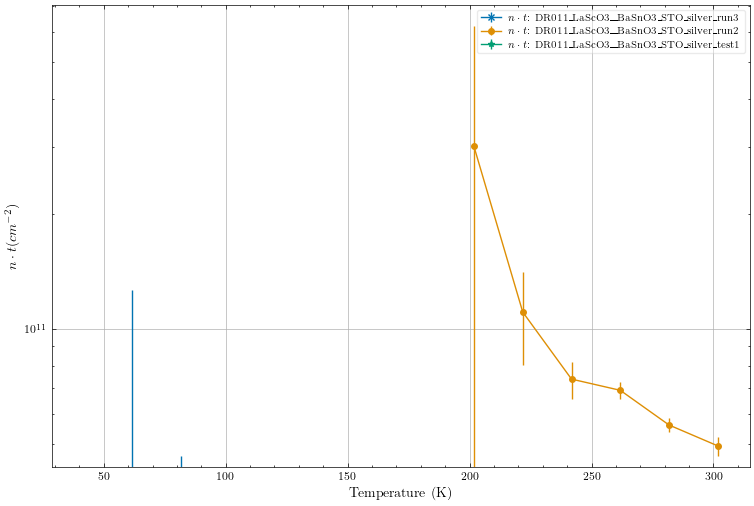

In [23]:
# Create a figure and axis
fig19 = plt.figure()
ax = fig19.add_subplot(111)  # Create a single subplot

# Set labels and title for either sheet resistance or resistivity
ax.set_xlabel('Temperature (K)')
if dat[0].film_thickness == 1:
    ax.set_ylabel(r'$n\cdot t$' r'($cm^{-2}$)')
    
    # set a label to pass as a prefix to the plot string
    n_label = r'$n\cdot t$: '
    #ax.set_title(r'$n\cdot t$ vs Temperature (2DEG)')
else:
    ax.set_ylabel(r'n($cm^{-3}$)')
    # set a label to pass as a prefix to the plot string
    n_label = r'$n$: '
    #ax.set_title(r'Charge Carrier Density vs Temperature') 
    
    
for j, d in enumerate(dat):
    
    ax.errorbar(d.hall_coefficient[:, 0], d.hall_coefficient[:, 7],yerr = d.hall_coefficient[:, 8], fmt='-'+mark_p[j], label=f'{n_label}{d.plot_str}')

# Add a legend for the y-axis
ax.legend()

ax.set_yscale('log')
#ax.set_xlim(0, 304)

# Show the plot
plt.show()

if export_data == True:
    fig19.savefig(dat[0].directory.joinpath(f'{dat[0].plot_str}_n_only_vs_temperature.{fig_format}'), dpi=300, bbox_inches='tight', transparent=plot_transparency)


## Mobility Only

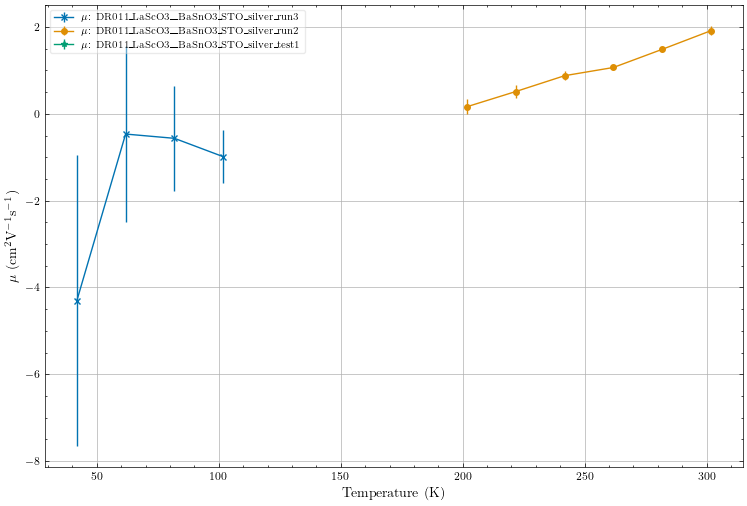

In [24]:
# Create a figure and axis
fig20 = plt.figure()
ax = fig20.add_subplot(111)  # Create a single subplot

# Plot data on the right y-axis
for j, d in enumerate(dat, start=0):

    ax.errorbar(d.hall_coefficient[:, 0], d.hall_coefficient[:, 9],yerr = d.hall_coefficient[:, 10], fmt='-'+mark_p[j],  label=r'$\mu$'f': {d.plot_str}')

# Set labels for the right y-axis
ax.set_ylabel(r'$\mu$ (cm$^2$V$^{-1}$s$^{-1}$)')

# Set labels and title for either sheet resistance or resistivity
ax.set_xlabel('Temperature (K)')

        
# Add a legend for the left y-axis
ax.legend()

#ax.set_ylim(0,14)


# Show the plot
plt.show()

if export_data == True:
    fig20.savefig(dat[0].directory.joinpath(f'{dat[0].plot_str}_u_only_vs_temperature.{fig_format}'), dpi=300, bbox_inches='tight', transparent=plot_transparency)

## $\rho_{xy}$ vs $\rho_{xx}$
- Can have problems where with both holes and electrons the carriers can cancel out the measured hall voltage
- Need to check this?

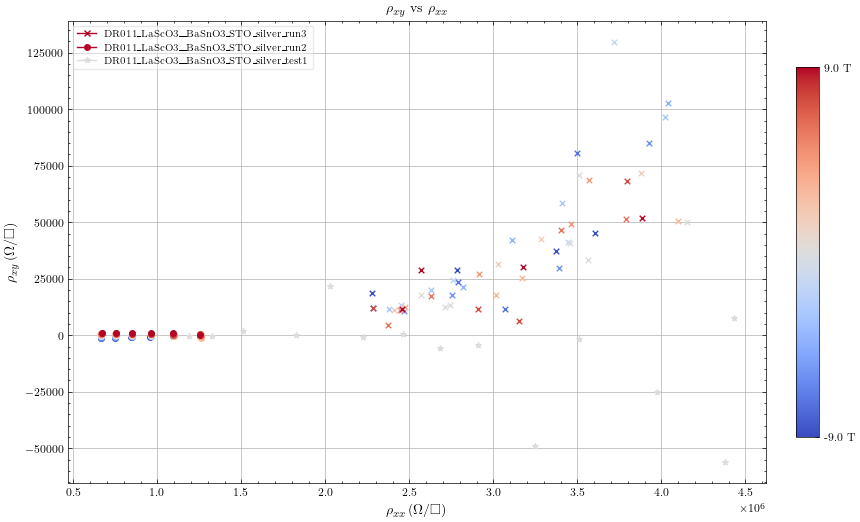

In [25]:
# Create a figure and GridSpec layout
fig21 = plt.figure(figsize= (fig_size[0] + fig_size[0]/9 , fig_size[1]) )
gs = gridspec.GridSpec(1, 2, width_ratios=[fig_size[0], fig_size[0]/9], wspace=0.0)

# Create the main plot
ax = fig21.add_subplot(gs[0])

# Add and adjust the colorbar using a custom function
sm = ScalarMappable(cmap=cmap_field, norm=norm_field)
add_colorbar(fig21, gs[1], sm, min_field, max_field, fig_size)

# Loop over the data sets
for j, d in enumerate(dat, start=0):
    for Bi, B in enumerate(d.ctf[2], start=0):
        # Plot rho_film vs Temp
        ax.scatter(d.res_data[:, Bi, 4] * unit_scale, d.hall_data[:, Bi, 6] * unit_scale, marker=mark_p[j], color=cmap_field(norm_field(B)))

    # Add a dummy plot for the legend entry
    ax.plot([], [], marker = mark_p[j], color = cmap_field(norm_field(B)), label=f'{d.plot_str}')

ax.set_title(r'$\rho_{xy}$ vs $\rho_{xx}$')
if dat[0].film_thickness == 1:
    ax.set_ylabel(r'$\rho_{xy}\,(\Omega/\square)$')
    ax.set_xlabel(r'$\rho_{xx}\,(\Omega/\square)$')

elif ohm_m == 1:
    ax.set_ylabel(r'$\rho_{xy}\,(\Omega \cdot m)$')
    ax.set_xlabel(r'$\rho_{xx}\,(\Omega \cdot m)$')
    
else:
    ax.set_ylabel(r'$\rho_{xy}\,(\mu \Omega \cdot cm)$')
    ax.set_xlabel(r'$\rho_{xx}\,(\mu \Omega \cdot cm)$')

# Add a legend
ax.legend()

# Show the plot
plt.show()

if export_data == True:
    fig21.savefig(dat[0].directory.joinpath(f'{dat[0].plot_str}_rho_xx_vs_rho_xy.{fig_format}'), dpi=300, bbox_inches='tight', transparent=plot_transparency)


##  Shubnikov–de Haas (SdH) oscillations

In [26]:
# # Create a figure and GridSpec layout
# fig22 = plt.figure(figsize= (fig_size[0] + fig_size[0]/9 , fig_size[1]) )
# gs = gridspec.GridSpec(1, 2, width_ratios=[fig_size[0], fig_size[0]/9], wspace=0.0)

# # Create the main plot
# ax = fig22.add_subplot(gs[0])
# ax2 = ax.twinx()

# # Add and adjust the colorbar using a custom function
# sm = ScalarMappable(cmap=cmap_temp, norm=norm_temp)
# add_colorbar(fig22, gs[1], sm, min_temp, max_temp, fig_size, field=False)

# cax = fig22.axes[-1]
# pos = cax.get_position()
# cax.set_position([
#     pos.x0 + 0.15, 
#     pos.y0,  
#     pos.width,  
#     pos.height  
# ])



# # Loop over the data sets
# for j, d in enumerate(dat):
#     # Loop over the temperatures
#     for Ti, T in enumerate(d.ctf[1], start=0):  
#         if T > 1:
#             ### Fitting to MR data
#             # Perform a quadratic fit on the Magnetoresistance data
#             #tf = [current_unique, temp_unique, field_unique, current_no, temp_no, field_no]
#             x_data_MR = d.tf_av[Ti,:,1] * 10
#             # Get modulus of x_data_MR
#             x_data_MR = np.abs(x_data_MR)
#             y_data_MR = d.mag_res[Ti, :, 2]
#             coeffs_MR = np.polyfit(x_data_MR, y_data_MR, 1)
#             polynomial_fit_MR = np.polyval(coeffs_MR, x_data_MR)

#             # Plot the original MR data and the quadratic fit
#             #ax.scatter(x_data_MR, y_data_MR, marker=mark_p[j], color='green')  # initial MR data
#             #ax.plot(x_data_MR, polynomial_fit_MR, color='blue')  # quadratic fit to MR data
#             ax.plot(x_data_MR, y_data_MR - polynomial_fit_MR, marker=mark_p[j], color='purple')  # Residual MR


#             ### Fitting to Hall data
#             index = Ti * d.ctf[5]
            
            
#             # Extract the positive and negative applied B of the Hall data
#             x_data_Hall_neg = d.hall_data[Ti, 0:int(d.ctf[5]/2), 1] * 10
#             y_data_Hall_neg = d.hall_data[Ti, 0:int(d.ctf[5]/2), 6] * unit_scale
#             x_data_Hall_pos = d.hall_data[Ti, int(d.ctf[5]/2):, 1] * 10
#             y_data_Hall_pos = d.hall_data[Ti, int(d.ctf[5]/2):, 6] * unit_scale

#             # Perform a linear fit on the negative Hall data
#             coeffs_Hall_neg = np.polyfit(x_data_Hall_neg, y_data_Hall_neg, 1)
#             polynomial_fit_Hall_neg = np.polyval(coeffs_Hall_neg, x_data_Hall_neg)
#             # Perform a linear fit on the positive Hall data
#             coeffs_hall_pos = np.polyfit(x_data_Hall_pos, y_data_Hall_pos, 1)
#             polynomial_fit_Hall_pos = np.polyval(coeffs_hall_pos, x_data_Hall_pos)
            
#             y_data_Hall_neg_res = y_data_Hall_neg - polynomial_fit_Hall_neg
#             #y_data_Hall_neg_res = scipy.signal.medfilt(y_data_Hall_neg_res, kernel_size=5)
#             y_data_Hall_pos_res = y_data_Hall_pos - polynomial_fit_Hall_pos
#             #y_data_Hall_pos_res = scipy.signal.medfilt(y_data_Hall_pos_res, kernel_size=5)
            
#             # Plot the original Hall data and the polynomial fit
#             # ax2.scatter(x_data_Hall_neg, y_data_Hall_neg, marker=mark_p[j], color='black')  # initial Hall data
#             # ax2.plot(x_data_Hall_neg, polynomial_fit_Hall_neg, color='black')  # polynomial fit to Hall data
#             # ax2.scatter(x_data_Hall_pos, y_data_Hall_pos, marker=mark_p[j], color='black')  # initial Hall data
#             # ax2.plot(x_data_Hall_pos, polynomial_fit_Hall_pos, color='black')  # polynomial fit to Hall data
            
#             ax2.plot(-x_data_Hall_neg, y_data_Hall_neg_res, marker=mark_p[j], color='red') # Residual Hall for negative field
#             ax2.plot(x_data_Hall_pos, y_data_Hall_pos_res, marker=mark_p[j], color='orange') # Residual Hall for positive field
#             #ax2.plot(x_data_Hall_pos, (y_data_Hall_neg_res + y_data_Hall_pos_res)/2, marker=mark_p[j], color='black') # Average Residual Hall 
        
    
#     # Add a dummy plot for the legend entry
#     ax.plot([], [], marker = mark_p[j], color=cmap_temp(norm_temp(T)), label=f'{d.plot_str}')

        
# ax.set_xlabel('H (kOe)')
# ax.set_ylabel(r'Magnetoresistance (\%)')
# ax.set_title(f'Magnetoresistance and Hall Resistace - offsets removed - vs Field')
# ax.legend()

# ax2.set_ylabel(r'Hall Resistance ($\Omega/\square$)')

# #ax.set_xlim(60,90)
# #ax.set_ylim(-10,10)
# plt.show()

# if export_data == True:
#     fig22.savefig(dat[0].directory.joinpath(f'{dat[0].plot_str}_SDH_oscillations.{fig_format}'), dpi=300, bbox_inches='tight', transparent=plot_transparency)


## SDH $\frac{-d^2R_{xx}}{dB^2}$

In [27]:
# # Create a figure and GridSpec layout
# fig23 = plt.figure(figsize= (fig_size[0] + fig_size[0]/9 , fig_size[1]) )
# gs = gridspec.GridSpec(1, 2, width_ratios=[fig_size[0], fig_size[0]/9], wspace=0.0)

# # Create the main plot
# ax = fig23.add_subplot(gs[0])
# ax2 = ax.twinx()

# # Add and adjust the colorbar using a custom function
# sm = ScalarMappable(cmap=cmap_temp, norm=norm_temp)
# add_colorbar(fig23, gs[1], sm, min_temp, max_temp, fig_size, field=False)

# cax = fig23.axes[-1]
# pos = cax.get_position()
# cax.set_position([
#     pos.x0 + 0.15, 
#     pos.y0,  
#     pos.width,  
#     pos.height  
# ])



# # Loop over the data sets
# for j, d in enumerate(dat):
#     # Loop over the temperatures
#     for Ti, T in enumerate(d.ctf[1], start=0):  
#         if T > 1:
            
#             ### Compute the second derivative of the longitudinal sheet resistance with respect to the magnetic field
#             B_field = d.hall_data[Ti,:, 1] * 10 # Magnetic field
            
#             Rsxx = d.res_data[Ti, :, 4] # Sheet resistance
            
#             # Get the indices that would sort B_field in ascending order
#             sorted_indices = np.argsort(B_field)

#             # Sort B_field and Rsxx using the sorted indices
#             B_field_sorted = B_field#[sorted_indices]
#             Rsxx_sorted = Rsxx#[sorted_indices]

#             # Compute the first and second derivatives
#             dRsxx_dB = np.gradient(Rsxx_sorted, B_field_sorted)
#             d2Rsxx_dB2 = np.gradient(dRsxx_dB, B_field_sorted)
            

#             ax.plot(1/B_field_sorted, -d2Rsxx_dB2, marker=mark_p[j], color='green')
            
#             ### Compute the second derivative of the hall resistance with respect to the magnetic field
#             Rsxy = d.hall_data[Ti, :, 6] # Hall resistivity
#             Rsxy_sorted = Rsxy[sorted_indices]
            
#             # Compute the first and second derivatives
#             dRsxy_dB = np.gradient(Rsxy_sorted, B_field_sorted)
#             d2Rsxy_dB2 = np.gradient(dRsxy_dB, B_field_sorted)
            
#             ax2.plot(1/B_field_sorted, -d2Rsxy_dB2, marker=mark_p[j], color='blue')


    
#     # Add a dummy plot for the legend entry
#     ax.plot([], [], marker = mark_p[j], color = cmap_temp(norm_temp(T)), label=f'{d.plot_str}')

        
# ax.set_xlabel(r'Inverse Magnetic Field ($1/B$)')
# ax.set_ylabel(r'$-d^2R_{xx}/dB^2 \, (\Omega/ \square T^2)$')
# ax.set_title(r'Second Derivative of Longitudinal Sheet Resistance')
# ax.legend()


# ax.set_xlim(0, 0.1)
# ax.set_ylim(-0.005, 0.005)
# ax2.set_ylim(-0.005, 0.005)

# #plt.tight_layout()
# plt.show()

# if export_data == True:
#     fig23.savefig(dat[0].directory.joinpath(f'{dat[0].plot_str}_Second_Derivative_of_MR.{fig_format}'), dpi=300, bbox_inches='tight', transparent=plot_transparency)


## Powerpoint Export

In [28]:
if export_data == True:
    # Create a PowerPoint presentation object
    prs = Presentation()

    # Define a function to add a slide with a title and image
    def add_slide(prs, title, fig):
        # Check if figure exists and is valid
        if fig is None or not hasattr(fig, 'axes') or len(fig.axes) == 0:
            print(f"Skipping '{title}': Figure does not exist or is empty")
            return
            
        slide_layout = prs.slide_layouts[5]  # Use a blank slide layout
        slide = prs.slides.add_slide(slide_layout)
        
        # Set background color with 40% transparency
        background = slide.background
        fill = background.fill
        fill.solid()
        fill.fore_color.rgb = RGBColor(200, 200, 200)

        # Add title with custom font
        title_shape = slide.shapes.title
        title_shape.text = title
        title_shape.text_frame.paragraphs[0].font.size = Pt(24)
        title_shape.text_frame.paragraphs[0].font.bold = True
        title_shape.text_frame.paragraphs[0].font.color.rgb = RGBColor(0, 0, 0)
        title_shape.text_frame.paragraphs[0].font.name = 'Arial'
        title_shape.text_frame.paragraphs[0].alignment = PP_ALIGN.CENTER

        # Save the figure as an image
        img_path = dat[0].directory.joinpath(f'{title}.png')
        try:
            fig.savefig(img_path, dpi=300, bbox_inches='tight', transparent=True)
        except Exception as e:
            print(f"Error saving figure '{title}': {e}")
            return
               
        # Calculate the left position to center the image
        slide_width = prs.slide_width
        image_width = Inches(fig_size[0])
        left = (slide_width - image_width) / 2
        top = Inches(2)  # Position the figure lower down by 2 inches
        
        # Add the image to the slide
        pic = slide.shapes.add_picture(str(img_path), left, top, width=image_width)
        print(f"Added slide: {title}")

    # List of figures and their corresponding titles
    figures = [
        (fig1, "Plot IV data from Resistivity Measurement to Check Linearity"),
        (fig2, "R-squared Analysis to Check Linearity of I-V Resistivity data"),
        (fig3, "Resistivity Configuration Compararison"),
        (fig4, "Resistivity vs Temperature"),
        (fig5, "Resistivity vs Temperature at B=0"),
        (fig6, "Resistivity vs H"),
        (fig7, "Magnetoresistance vs H"),
        (fig8, "Magnetoresistance Vs T"),
        (fig9, "Arhenius Plot"),
        (fig10, "Log(R) vs Log(T)"),
        (fig11, "Plot IV data of Hall Measurement to Check Linearity"),
        (fig12, "R-squared Analysis to Check Linearity of Resistivity I-V data"),
        (fig13, "Hall resisitivity vs Temperature"),
        (fig14, "Hall resisitivity vs Applied Field"),
        (fig15, "Hall resisitivity vs Applied Field - Offset Removed"),
        (fig16, "Charge Carrier Density Vs T"),
        (fig17, "Mobility vs T"),
        (fig18, "Mobility and Charge Carrier Density vs T"),
        (fig19, "Charge Carrier Density Vs T"),
        (fig20, "Mobility vs T"),       
        (fig21, "ρ_xy vs ρ_xx"),
        (fig22, "Shubnikov–de Haas Oscillations"),
        (fig23, "Second_Derivative_of_MR"),
    ]

    # Add each figure to the PowerPoint presentation if it exists
    for fig, title in figures:
        add_slide(prs, title, fig)

    # Save the PowerPoint presentation
    prs.save(dat[0].directory.joinpath(f'{dat[0].filename}_{powerpoint_string}.pptx'))